https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [2]:
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import multiprocessing as mp
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import random 
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from  tqdm import tqdm
import gc
from functools import partial
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "../input/"

pd.set_option("display.max_columns", 2000)

import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [2]:
with timer('read application_train.csv'):
    app_train = pd.read_csv(path + "application_train.csv")

read application_train.csv - done in 6s


In [3]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [4]:
with timer('read bureau.csv'):
    bureau = pd.read_csv(path + "bureau.csv")

read bureau.csv - done in 3s


In [5]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
with timer('read bureau_balance.csv'):
    bureau_balance = pd.read_csv(path + "bureau_balance.csv")

read bureau_balance.csv - done in 7s


In [7]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [8]:
with timer('read credit_card_balance.csv'):
    credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")

read credit_card_balance.csv - done in 10s


In [9]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [10]:
with timer('read POS_CASH_balance.csv'):
    pcb = pd.read_csv(path + "POS_CASH_balance.csv")

read POS_CASH_balance.csv - done in 7s


In [11]:
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [12]:
with timer('read previous_application.csv'):
    previous_application = pd.read_csv(path + "previous_application.csv")

read previous_application.csv - done in 8s


In [13]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
with timer('read installments_payments.csv'):
    installments_payments = pd.read_csv(path + "installments_payments.csv")

read installments_payments.csv - done in 13s


In [15]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## 学習データ準備

In [16]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb


with timer('read application_test.csv'):
    app_test = pd.read_csv('../input/application_test.csv')


with timer('perapare'):
    app_test['is_test'] = 1 
    app_test['is_train'] = 0
    app_train['is_test'] = 0
    app_train['is_train'] = 1

    # target variable
    Y = app_train['TARGET']
    train_X = app_train.drop(['TARGET'], axis = 1)

    # test ID
    test_id = app_test['SK_ID_CURR']
    test_X = app_test

    # merge train and test datasets for preprocessing
    data = pd.concat([train_X, test_X], axis=0)

read application_test.csv - done in 1s
perapare - done in 1s


### <a id="0.1">0.1 Prepare - Data Cleaning</a>

In [17]:

with timer('app remove meaningless feature'):
    data.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)

with timer('replace outliers'):
    data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    data['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
    data['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
    data['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)
    data['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    data.loc[data['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
    data.loc[data['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
    data.loc[data['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
    data.loc[data['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
    data.loc[data['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan


app remove meaningless feature - done in 1s
replace outliers - done in 1s


In [18]:
with timer('bureau replace outliers'):
    bureau['AMT_CREDIT_SUM'].fillna(0, inplace=True)
    bureau['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)
    bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0, inplace=True)
    bureau['CNT_CREDIT_PROLONG'].fillna(0, inplace=True)

    bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] < -40000] = np.nan
    bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] < -40000] = np.nan
    bureau['DAYS_ENDDATE_FACT'][bureau['DAYS_ENDDATE_FACT'] < -40000] = np.nan

bureau replace outliers - done in 0s


In [19]:
with timer('previous_application replace outliers'):
    previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
      

previous_application replace outliers - done in 0s


In [20]:
with timer('credit_card_balance replace outliers'):
    credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'][credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] < 0] = np.nan
    credit_card_balance['AMT_DRAWINGS_CURRENT'][credit_card_balance['AMT_DRAWINGS_CURRENT'] < 0] = np.nan

credit_card_balance replace outliers - done in 0s


## feature engineering

In [21]:
with timer('app features1'):
    
    data['app NAN num'] = data.isnull().sum(axis = 1).values        

    data['app CNT_FAM_MEMBERS - CNT_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']        
    
    data['app AMT_CREDIT / AMT_ANNUITY'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app AMT_CREDIT / AMT_ANNUITY / DAYS_EMPLOYED'] = data['app AMT_CREDIT / AMT_ANNUITY'] / data['DAYS_EMPLOYED']
    data['app AMT_CREDIT / AMT_INCOME_TOTAL'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app AMT_CREDIT - AMT_GOODS_PRICE'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
    data['app AMT_CREDIT / AMT_GOODS_PRICE'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    data['app AMT_CREDIT / CNT_FAM_MEMBERS'] = data['AMT_CREDIT'] / data['CNT_FAM_MEMBERS']
    data['app AMT_CREDIT / (1 + CNT_CHILDREN)'] = data['AMT_CREDIT'] / (1 + data['CNT_CHILDREN'])
    data['app AMT_CREDIT / (CNT_FAM_MEMBERS - CNT_CHILDREN)'] = data['AMT_CREDIT'] / data['app CNT_FAM_MEMBERS - CNT_CHILDREN']   
    
    data['app AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app AMT_ANNUITY / AMT_CREDIT'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    
    data['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / 12. - data['AMT_ANNUITY']
    data['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / data['AMT_ANNUITY']
    data['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = data['AMT_INCOME_TOTAL'] - data['AMT_GOODS_PRICE']
    data['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])       
    data['app AMT_INCOME_TOTAL / AMT_CREDIT'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
    data['app AMT_INCOME_TOTAL / (CNT_FAM_MEMBERS - CNT_CHILDREN) '] = data['AMT_INCOME_TOTAL'] / data['app CNT_FAM_MEMBERS - CNT_CHILDREN']
    
    data['app DAYS_EMPLOYED / DAYS_BIRTH'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    data['app EXT_SOURCE mean'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    data['app EXT_SOURCE std'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
    data['app EXT_SOURCE prod'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
    data['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = data['EXT_SOURCE_1'] * data['DAYS_EMPLOYED']
    data['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = data['EXT_SOURCE_2'] * data['DAYS_EMPLOYED']
    data['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = data['EXT_SOURCE_3'] * data['DAYS_EMPLOYED']
    data['app EXT_SOURCE_1 / DAYS_BIRTH'] = data['EXT_SOURCE_1'] / data['DAYS_BIRTH']
    data['app EXT_SOURCE_2 / DAYS_BIRTH'] = data['EXT_SOURCE_2'] / data['DAYS_BIRTH']
    data['app EXT_SOURCE_3 / DAYS_BIRTH'] = data['EXT_SOURCE_3'] / data['DAYS_BIRTH']

    data['app OWN_CAR_AGE / DAYS_BIRTH'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
    data['app OWN_CAR_AGE / DAYS_EMPLOYED'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']

    data['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']
    data['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_EMPLOYED']

    data['app DAYS_EMPLOYED - DAYS_BIRTH'] = data['DAYS_EMPLOYED'] - data['DAYS_BIRTH']
    data['app DAYS_EMPLOYED / DAYS_BIRTH'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['app DAYS_EMPLOYED - DAYS_REGISTRATION'] = data['DAYS_EMPLOYED'] - data['DAYS_REGISTRATION']
    data['app DAYS_EMPLOYED - DAYS_ID_PUBLISH'] = data['DAYS_EMPLOYED'] - data['DAYS_ID_PUBLISH']
    
    data['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']
    data['app CNT_CHILDREN / CNT_CHILDREN'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']
    data['app CNT_CHILDREN / (CNT_FAM_MEMBERS - CNT_CHILDREN)'] = data['CNT_CHILDREN'] / data['app CNT_FAM_MEMBERS - CNT_CHILDREN']
    
    data['app OBS_30_CNT_SOCIAL_CIRCLE - DEF_30_CNT_SOCIAL_CIRCLE'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] - data['DEF_30_CNT_SOCIAL_CIRCLE']
    data['app OBS_60_CNT_SOCIAL_CIRCLE - DEF_60_CNT_SOCIAL_CIRCLE'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] - data['DEF_60_CNT_SOCIAL_CIRCLE']
    
with timer('app features2'):
    data['app most popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                            .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
    data['app popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                            .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})
    data['app TOTAL_DOCS_SUBMITTED'] = data.loc[:, data.columns.str.contains('FLAG_DOCUMENT')].sum(axis=1)
    data['app DAYS_EMPLOYED < -2000'] = (data['DAYS_EMPLOYED'] < -2000).astype(int)
    data['DAYS_BIRTH < -14000'] = (data['DAYS_BIRTH'] < -14000).astype(int)


app features1 - done in 2s
app features2 - done in 1s


In [22]:
with timer('app features handcraft definition'):
    data['app self cate OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].replace(
                       {'High skill tech staff':0,
                        'Managers':0,
                        'Accountants':0,
                        'HR staff':0,
                        'Core staff':0,
                       'Cooking staff':1,
                        'Realty agents':0,
                        'Sales staff':1,
                        'IT staff':0,
                        'Medicine staff':0,
                        'Secretaries':0,
                        'Security staff':1,
                        'Cleaning staff':1,
                          'Laborers':1,
                          'Low-skill Laborers':1,
                          'Cleaning staff':1,
                        'Waiters/barmen staff':1,
                        'Private service staff':0,
                        'Drivers':1,
                        'High skill tech staff':0                                                                       
                        },inplace=False)

    data['app self cate NAME_INCOME_TYPE'] = data['NAME_INCOME_TYPE'].replace(
                        {'Businessman':0,
                         'Student':0,
                         'Unemployed':1,
                         'Working':1,
                         'Commercial associate':0,                        
                         'State servant':0,
                         'Pensioner':0,                         
                         'Maternity leave':1}
                        ,inplace=False)

    data['app self cate NAME_HOUSING_TYPE'] = data['NAME_HOUSING_TYPE'].replace(
                        {'Rented apartment':1,
                         'With parents':1,
                         'Municipal apartment':0,
                         'Co-op apartment':0,
                         'House / apartment':0,                        
                         'Office apartment':0}
                        ,inplace=False)

    data['app self cate ORGANIZATION_TYPE'] = data['ORGANIZATION_TYPE'].replace(
                        {'Transport':1, 
                        'Industry: type 13':1, 
                        'Industry: type 8':1, 
                        'Transport: type 3':1,
                        'Restaurant':1, 
                        'Construction':1,
                        'Cleaning':1,
                        'Industry: type 1':1,
                        'Industry: type 3':1,
                        'Realtor':1,
                        'Agriculture':1,
                        'Trade: type 3':1,
                        'Self-employed':1,
                        'Industry: type 4':1,
                        'Security':0,
                        'Trade: type 7':0,
                        'Business Entity Type 3':0,
                        'Transport: type 4':0,
                        'Mobile':0,
                        'Trade: type 1':0,
                        'Industry: type 11':0,
                        'Business Entity Type 2':0,
                        'Postal':0,
                        'Advertising':0,
                        'Business Entity Type 1':0,
                        'Industry: type 7':0,
                        'Housing':0,
                        'Legal Services':0,
                        'Transport: type 2':0,
                        'Other':0,
                        'Telecom':0,
                        'Industry: type 2':0,
                        'Industry: type 6':0,
                        'Emergency':0,
                        'Kindergarten':0,
                        'Trade: type 2':0,
                        'Government':0,
                        'Industry: type 5':0,
                        'Industry: type 9':0,
                        'Electricity':0,
                        'Services':0,
                        'Medicine':0,
                        'Industry: type 10':0,
                        'Hotel':0,
                        'Trade: type 5':0,
                        'School':0,
                        'Religion':0,
                        'Insurance':0,
                        'Culture':0,
                        'XNA':0,
                        'Bank':0,
                        'Military':0,
                        'Police':0,
                        'University':0,
                        'Security Ministries':0,
                        'Trade: type 6':0,
                        'Transport: type 1':0,
                        'Industry: type 12':0,
                        'Trade: type 4':0}
                        ,inplace=False)        

app features handcraft definition - done in 2s


In [23]:
with timer('app features handcraft'):
    ### 勝手にデータ定義して作ってみたものの、事実に基づいてないからダメかもしれない。あんまり足すのはやめておこう。
    # app self cate OCCUPATION_TYPE
    data['app self cate occ AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate occ AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate occ AMT_CREDIT / AMT_ANNUITY'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate occ DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate OCCUPATION_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # app self cate NAME_INCOME_TYPE
    data['app self cate income AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate income AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate income AMT_CREDIT / AMT_ANNUITY'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate income DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate NAME_INCOME_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # app self cate NAME_HOUSING_TYPE
    data['app self cate housing AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate housing AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate housing AMT_CREDIT / AMT_ANNUITY'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate housing DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate NAME_HOUSING_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # app self cate ORGANIZATION_TYPE
    data['app self cate org AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate org AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate org AMT_CREDIT / AMT_ANNUITY'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate org DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate ORGANIZATION_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    

app features handcraft - done in 0s


In [24]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_test,is_train,app NAN num,app CNT_FAM_MEMBERS - CNT_CHILDREN,app AMT_CREDIT / AMT_ANNUITY,app AMT_CREDIT / AMT_ANNUITY / DAYS_EMPLOYED,app AMT_CREDIT / AMT_INCOME_TOTAL,app AMT_CREDIT - AMT_GOODS_PRICE,app AMT_CREDIT / AMT_GOODS_PRICE,app AMT_CREDIT / CNT_FAM_MEMBERS,app AMT_CREDIT / (1 + CNT_CHILDREN),app AMT_CREDIT / (CNT_FAM_MEMBERS - CNT_CHILDREN),app AMT_ANNUITY / AMT_INCOME_TOTAL,app AMT_ANNUITY / AMT_CREDIT,app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY,app AMT_INCOME_TOTAL / AMT_ANNUITY,app AMT_INCOME_TOTAL - AMT_GOODS_PRICE,app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS,app AMT_INCOME_TOTAL / CNT_CHILDREN,app AMT_INCOME_TOTAL / AMT_CREDIT,app AMT_INCOME_TOTAL / (CNT_FAM_MEMBERS - CNT_CHILDREN),app DAYS_EMPLOYED / DAYS_BIRTH,app EXT_SOURCE mean,app EXT_SOURCE std,app EXT_SOURCE prod,app EXT_SOURCE_1 * DAYS_EMPLOYED,app EXT_SOURCE_2 * DAYS_EMPLOYED,app EXT_SOURCE_3 * DAYS_EMPLOYED,app EXT_SOURCE_1 / DAYS_BIRTH,app EXT_SOURCE_2 / DAYS_BIRTH,app EXT_SOURCE_3 / DAYS_BIRTH,app OWN_CAR_AGE / DAYS_BIRTH,app OWN_CAR_AGE / DAYS_EMPLOYED,app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH,app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED,app DAYS_EMPLOYED - DAYS_BIRTH,app DAYS_EMPLOYED - DAYS_REGISTRATION,app DAYS_EMPLOYED - DAYS_ID_PUBLISH,app CNT_CHILDREN / CNT_FAM_MEMBERS,app CNT_CHILDREN / CNT_CHILDREN,app CNT_CHILDREN / (CNT_FAM_MEMBERS - CNT_CHILDREN),app OBS_30_CNT_SOCIAL_CIRCLE - DEF_30_CNT_SOCIAL_CIRCLE,app OBS_60_CNT_SOCIAL_CIRCLE - DEF_60_CNT_SOCIAL_CIRCLE,app most popular AMT_GOODS_PRICE,app popular AMT_GOODS_PRICE,app TOTAL_DOCS_SUBMITTED,app DAYS_EMPLOYED < -2000,DAYS_BIRTH < -14000,app self cate OCCUPATION_TYPE,app self cate NAME_INCOME_TYPE,app self cate NAME_HOUSING_TYPE,app self cate ORGANIZATION_TYPE,app self cate occ AMT_CREDIT / AMT_INCOME_TOTAL,app self cate occ AMT_ANNUITY / AMT_INCOME_TOTAL,app self cate occ AMT_CREDIT / AMT_ANNUITY,app self cate occ DAYS_EMPLOYED / DAYS_BIRTH,app self cate income AMT_CREDIT / AMT_INCOME_TOTAL,app self cate income AMT_ANNUITY / AMT_

In [25]:
with timer('app groupby features define'):
    APP_AGGREGATION_RECIPIES = [
        (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                                  ('AMT_CREDIT', 'max'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('OWN_CAR_AGE', 'max'),
                                                  ('OWN_CAR_AGE', 'sum')]),
#        (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
#                                                ('AMT_INCOME_TOTAL', 'mean'),
#                                                ('DAYS_REGISTRATION', 'mean'),
#                                                ('EXT_SOURCE_1', 'mean')]),
 #       (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
 #                                                    ('CNT_CHILDREN', 'mean'),
 #                                                    ('DAYS_ID_PUBLISH', 'mean')]),
        (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                               ('EXT_SOURCE_2', 'mean')]),
        (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                      ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                      ('APARTMENTS_AVG', 'mean'),
                                                      ('BASEMENTAREA_AVG', 'mean'),
                                                      ('EXT_SOURCE_1', 'mean'),
                                                      ('EXT_SOURCE_2', 'mean'),
                                                      ('EXT_SOURCE_3', 'mean'),
                                                      ('NONLIVINGAREA_AVG', 'mean'),
                                                      ('OWN_CAR_AGE', 'mean'),
                                                      ('YEARS_BUILD_AVG', 'mean')]),
#        (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
#                                                                                ('EXT_SOURCE_1', 'mean')]),
#        (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
#                               ('CNT_CHILDREN', 'mean'),
#                               ('CNT_FAM_MEMBERS', 'mean'),
#                               ('DAYS_BIRTH', 'mean'),
#                               ('DAYS_EMPLOYED', 'mean'),
#                               ('DAYS_ID_PUBLISH', 'mean'),
#                               ('DAYS_REGISTRATION', 'mean'),
#                               ('EXT_SOURCE_1', 'mean'),
#                               ('EXT_SOURCE_2', 'mean'),
#                               ('EXT_SOURCE_3', 'mean')]),
#        (['NAME_CONTRACT_TYPE'], [('app AMT_CREDIT / AMT_ANNUITY', 'mean'),
#                                  ('app EXT_SOURCE mean', 'max'),
#                                  ('app DAYS_EMPLOYED / DAYS_BIRTH', 'mean')]),
        (['REGION_RATING_CLIENT', 'NAME_HOUSING_TYPE'], [('AMT_CREDIT', 'mean'),
                                                      ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                      ('APARTMENTS_AVG', 'mean'),
                                                      ('BASEMENTAREA_AVG', 'mean'),
                                                      ('EXT_SOURCE_1', 'mean'),
                                                      ('EXT_SOURCE_2', 'mean'),
                                                      ('EXT_SOURCE_3', 'mean'),
                                                      ('NONLIVINGAREA_AVG', 'mean'),
                                                      ('OWN_CAR_AGE', 'mean'),
                                                      ('YEARS_BUILD_AVG', 'mean')]),
#        (['CODE_GENDER', 'NAME_INCOME_TYPE'], [('AMT_ANNUITY', 'mean'),
#                                                ('app AMT_CREDIT / AMT_ANNUITY', 'mean'),
#                                                ('DAYS_REGISTRATION', 'mean'),
#                                                ('OWN_CAR_AGE', 'mean'),                                               
#                                                ('EXT_SOURCE_1', 'mean')]), 
    ]

app groupby features define - done in 0s


In [26]:
def make_agg_all_with_diff_by_recipies(targetData, RECIPES, prefix):
    agg_list = ['mean']
    select_list = targetData.columns
    groupby_aggregate_names = []
    for groupby_cols, specs in tqdm(RECIPES):
        group_object = targetData.groupby(groupby_cols)
        for select in tqdm(select_list):
            for agg in tqdm(agg_list):
                if (select == 'SK_ID_CURR'):
                    continue            
                if (targetData[select].dtype == 'object'):
                    continue
                bFound = False
                for col in groupby_cols:
                    if (col == select):
                        bFound = True
                if (bFound):
                    continue
                    
                groupby_aggregate_name = '{}_{}_{}_{}'.format(prefix, '_'.join(groupby_cols), agg, select)
                diff_name = '{}_diff'.format(groupby_aggregate_name)                                
                targetData = targetData.merge(group_object[select]
                                      .agg(agg)
                                      .reset_index()
                                      .rename(index=str,
                                              columns={select: groupby_aggregate_name})
                                      [groupby_cols + [groupby_aggregate_name]],
                                      on=groupby_cols,
                                      how='left')
                targetData[diff_name] = targetData[select] - targetData[groupby_aggregate_name] 
    return targetData

In [27]:
def make_agg_by_recipies(targetData, RECIPES, prefix):
    groupby_aggregate_names = []
    for groupby_cols, specs in tqdm(RECIPES):
        group_object = targetData.groupby(groupby_cols)
        for select, agg in tqdm(specs):
            groupby_aggregate_name = '{}_{}_{}_{}'.format(prefix, '_'.join(groupby_cols), agg, select)
            targetData = targetData.merge(group_object[select]
                                  .agg(agg)
                                  .reset_index()
                                  .rename(index=str,
                                          columns={select: groupby_aggregate_name})
                                  [groupby_cols + [groupby_aggregate_name]],
                                  on=groupby_cols,
                                  how='left')
            groupby_aggregate_names.append(groupby_aggregate_name)
    return targetData

In [28]:
with timer('app groupby features'):
    data  = make_agg_all_with_diff_by_recipies(data, APP_AGGREGATION_RECIPIES, 'app all')    
    data  = make_agg_by_recipies(data, APP_AGGREGATION_RECIPIES, 'app ')

  0%|                                                                                          | 0/178 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████

KeyboardInterrupt: 

In [ ]:
data.head()

In [ ]:
with timer('categorical data processing function'):
    # function to obtain Categorical Features
    def _get_categorical_features(df):
        feats = [col for col in list(df.columns) if df[col].dtype == 'object']
        return feats

    # function to factorize categorical features
    def _factorize_categoricals(df, cats):
        for col in cats:
            df[col], _ = pd.factorize(df[col])
        return df 

    # function to create dummy variables of categorical features
    def _get_dummies(df, cats):
        for col in cats:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        return df 

In [ ]:
with timer('categorical data processing'):
    # get categorical features
    data_cats = _get_categorical_features(data)
    # factorize the categorical features from train and test data
    data = _factorize_categoricals(data, data_cats)

### <a id="1.1">1.1 Feature Engineering - Previous Applications</a>

In [ ]:
with timer('previous_application merged'):   
    pos_avg = pcb.drop(['SK_ID_CURR'], axis = 1).groupby('SK_ID_PREV').mean()
    pos_avg.columns = ['pre_pcb ' + col + '_mean' for col in pos_avg.columns]
    previous_application = previous_application.merge(right=pos_avg.reset_index(), how='left', on='SK_ID_PREV')
    ins_avg = installments_payments.drop(['SK_ID_CURR'], axis = 1).groupby('SK_ID_PREV').mean()
    ins_avg.columns = ['pre_ins ' + col + '_mean' for col in ins_avg.columns]
    previous_application = previous_application.merge(right=ins_avg.reset_index(), how='left', on='SK_ID_PREV')
    ccb_avg = credit_card_balance.drop(['SK_ID_CURR'], axis = 1).groupby('SK_ID_PREV').mean()
    ccb_avg.columns = ['pre_ccb ' + col + '_mean' for col in ccb_avg.columns]
    previous_application = previous_application.merge(right=ccb_avg.reset_index(), how='left', on='SK_ID_PREV')
    del pos_avg, ins_avg, ccb_avg
    gc.collect()   

In [ ]:
with timer('previous_application features'):    
    ## count the number of previous applications for a given ID
    prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    previous_application['pre SK_ID_PREV_CNT'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])
    previous_application.drop(['SK_ID_PREV'], axis = 1, inplace = True)

    # nan num
    previous_application['pre NAN num'] = previous_application.isnull().sum(axis = 1).values


with timer('previous_application features'):
    # feature
    previous_application['pre AMT_APPLICATION / AMT_CREDIT'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
    previous_application['pre AMT_CREDIT / AMT_ANNUITY'] = previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']
    previous_application['pre AMT_CREDIT - AMT_GOODS_PRICE'] = previous_application['AMT_CREDIT'] - previous_application['AMT_GOODS_PRICE']        
    previous_application['pre AMT_CREDIT / AMT_GOODS_PRICE'] = previous_application['AMT_CREDIT'] / previous_application['AMT_GOODS_PRICE']    
    previous_application['pre AMT_ANNUITY / AMT_CREDIT'] = previous_application['AMT_CREDIT'] / previous_application['AMT_GOODS_PRICE']    

    previous_application['pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE'] = previous_application['DAYS_LAST_DUE_1ST_VERSION'] - previous_application['DAYS_LAST_DUE']
    previous_application['pre DAYS_LAST_DUE - DAYS_TERMINATION'] = previous_application['DAYS_LAST_DUE'] - previous_application['DAYS_TERMINATION']
    
    previous_application['pre AMT_GOODS_PRICE / CNT_PAYMENT'] = previous_application['AMT_GOODS_PRICE'] / previous_application['CNT_PAYMENT']    
    
    
    
with timer('merged data features'):
    previous_application['mer pre_pcb MONTHS_BALANCE_mean - pre_ccb MONTHS_BALANCE_mean'] = previous_application['pre_pcb MONTHS_BALANCE_mean'] - previous_application['pre_ccb MONTHS_BALANCE_mean']

    previous_application['mer DAYS_FIRST_DUE - pre_ins DAYS_INSTALMENT_mean'] = previous_application['DAYS_FIRST_DUE'] - previous_application['pre_ins DAYS_INSTALMENT_mean']
    previous_application['mer DAYS_FIRST_DUE - pre_ins DAYS_ENTRY_PAYMENT_mean'] = previous_application['DAYS_FIRST_DUE'] - previous_application['pre_ins DAYS_ENTRY_PAYMENT_mean']    
    previous_application['mer DAYS_LAST_DUE - pre_ins DAYS_INSTALMENT_mean'] = previous_application['DAYS_LAST_DUE'] - previous_application['pre_ins DAYS_INSTALMENT_mean']
    previous_application['mer DAYS_LAST_DUE - pre_ins DAYS_ENTRY_PAYMENT_mean'] = previous_application['DAYS_LAST_DUE'] - previous_application['pre_ins DAYS_ENTRY_PAYMENT_mean']    
    previous_application['mer DAYS_LAST_DUE_1ST_VERSION - pre_ins DAYS_INSTALMENT_mean'] = previous_application['DAYS_LAST_DUE_1ST_VERSION'] - previous_application['pre_ins DAYS_INSTALMENT_mean']
    previous_application['mer DAYS_LAST_DUE_1ST_VERSION - pre_ins DAYS_ENTRY_PAYMENT_mean'] = previous_application['DAYS_LAST_DUE_1ST_VERSION'] - previous_application['pre_ins DAYS_ENTRY_PAYMENT_mean']    

    previous_application['mer AMT_APPLICATION / pre_ins AMT_INSTALMENT_mean'] = previous_application['AMT_APPLICATION'] / previous_application['pre_ins AMT_INSTALMENT_mean']
    previous_application['mer AMT_APPLICATION / pre_ins AMT_PAYMENT_mean'] = previous_application['AMT_APPLICATION'] / previous_application['pre_ins AMT_PAYMENT_mean']
    previous_application['mer AMT_CREDIT / pre_ins AMT_INSTALMENT_mean'] = previous_application['AMT_CREDIT'] / previous_application['pre_ins AMT_INSTALMENT_mean']
    previous_application['mer AMT_CREDIT / pre_ins AMT_PAYMENT_mean'] = previous_application['AMT_CREDIT'] / previous_application['pre_ins AMT_PAYMENT_mean']
    previous_application['mer AMT_GOODS_PRICE / pre_ins AMT_INSTALMENT_mean'] = previous_application['AMT_GOODS_PRICE'] / previous_application['pre_ins AMT_INSTALMENT_mean']
    previous_application['mer AMT_GOODS_PRICE / pre_ins AMT_PAYMENT_mean'] = previous_application['AMT_GOODS_PRICE'] / previous_application['pre_ins AMT_PAYMENT_mean']

    previous_application['mer CNT_PAYMENT / pre_pcb CNT_INSTALMENT_mean'] = previous_application['CNT_PAYMENT'] / previous_application['pre_pcb CNT_INSTALMENT_mean']
    previous_application['mer CNT_PAYMENT / pre_pcb CNT_INSTALMENT_FUTURE_mean'] = previous_application['CNT_PAYMENT'] / previous_application['pre_pcb CNT_INSTALMENT_FUTURE_mean']
    previous_application['mer CNT_PAYMENT / pre_ccb CNT_DRAWINGS_ATM_CURRENT_mean'] = previous_application['CNT_PAYMENT'] / previous_application['pre_ccb CNT_DRAWINGS_ATM_CURRENT_mean']
    previous_application['mer CNT_PAYMENT / pre_ccb CNT_INSTALMENT_MATURE_CUM_mean'] = previous_application['CNT_PAYMENT'] / previous_application['pre_ccb CNT_INSTALMENT_MATURE_CUM_mean']

    previous_application['mer pre_ccb CNT_DRAWINGS_ATM_CURRENT_mean / pre_pcb CNT_INSTALMENT_mean'] = previous_application['pre_ccb CNT_DRAWINGS_ATM_CURRENT_mean'] / previous_application['pre_pcb CNT_INSTALMENT_mean']
    previous_application['mer pre_ccb CNT_DRAWINGS_ATM_CURRENT_mean / pre_pcb CNT_INSTALMENT_FUTURE_mean'] = previous_application['pre_ccb CNT_DRAWINGS_ATM_CURRENT_mean'] / previous_application['pre_pcb CNT_INSTALMENT_FUTURE_mean']
    previous_application['mer pre_ccb CNT_INSTALMENT_MATURE_CUM_mean / pre_pcb CNT_INSTALMENT_mean'] = previous_application['pre_ccb CNT_INSTALMENT_MATURE_CUM_mean'] / previous_application['pre_pcb CNT_INSTALMENT_mean']
    previous_application['mer pre_ccb CNT_INSTALMENT_MATURE_CUM_mean / pre_pcb CNT_INSTALMENT_FUTURE_mean'] = previous_application['pre_ccb CNT_INSTALMENT_MATURE_CUM_mean'] / previous_application['pre_pcb CNT_INSTALMENT_FUTURE_mean']
    
    

In [ ]:
with timer('previous_application groupby features define'):
    PRE_AGGREGATION_RECIPIES = [
        (['NAME_CONTRACT_TYPE'], [('pre AMT_CREDIT / AMT_ANNUITY', 'max'),
                                  ('pre AMT_GOODS_PRICE / CNT_PAYMENT', 'max'),
                                  ('pre AMT_ANNUITY / AMT_CREDIT', 'max'),                                  
                                  ('pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE', 'max') 
                                           ]),
        (['NAME_CASH_LOAN_PURPOSE'], [('pre AMT_CREDIT / AMT_ANNUITY', 'max'),
                                  ('pre AMT_GOODS_PRICE / CNT_PAYMENT', 'max'),
                                  ('pre AMT_ANNUITY / AMT_CREDIT', 'max'),                                  
                                  ('pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE', 'max') 
                                           ]),        
        (['NAME_PAYMENT_TYPE'], [('pre AMT_CREDIT / AMT_ANNUITY', 'max'),
                                  ('pre AMT_GOODS_PRICE / CNT_PAYMENT', 'max'),
                                  ('pre AMT_ANNUITY / AMT_CREDIT', 'max'),                                  
                                  ('pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE', 'max') 
                                           ]),        
        (['NAME_CONTRACT_STATUS', 'NAME_CASH_LOAN_PURPOSE'], [('pre AMT_CREDIT / AMT_ANNUITY', 'max'),
                                  ('pre AMT_GOODS_PRICE / CNT_PAYMENT', 'max'),
                                  ('pre AMT_ANNUITY / AMT_CREDIT', 'max'),                                  
                                  ('pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE', 'max'), 
                                  ('pre DAYS_LAST_DUE - DAYS_TERMINATION', 'max'),                                                               
                                           ]),                
    ]
    

In [ ]:
previous_application.head()

In [ ]:
with timer('previous_application groupby features, diff'):
    previous_application  = make_agg_by_recipies(previous_application, PRE_AGGREGATION_RECIPIES, 'pre ')
    previous_application  = make_agg_all_with_diff_by_recipies(previous_application, PRE_AGGREGATION_RECIPIES, 'pre all')   

In [ ]:
with timer('previous_application features categorical'):
    prev_app_cats = _get_categorical_features(previous_application)
    previous_application = _get_dummies(previous_application, prev_app_cats)

with timer('previous_application features mean'):
    ## Average values for all other features in previous applications
    prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
    prev_apps_avg.columns = ['pre ' + col + '_mean' for col in prev_apps_avg.columns]
    data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')
    del prev_apps_avg
    gc.collect()

with timer('previous_application features agg by self choice'):
    num_aggregations = {
            'AMT_ANNUITY': ['min', 'max', 'mean', 'var'],
            'AMT_APPLICATION': ['min', 'max', 'mean', 'var'],
            'AMT_CREDIT': ['min', 'max', 'mean', 'var'],
            'pre AMT_APPLICATION / AMT_CREDIT': ['min', 'max', 'mean', 'var'],
            'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'var'],
            'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'var'],
            'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', 'var'],
            'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', 'var'],
            'DAYS_DECISION': ['min', 'max', 'mean', 'var'],
            'CNT_PAYMENT': ['min', 'max', 'mean', 'var'],
    }

    cat_aggregations = {}

    prev_agg = previous_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['pre ' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

with timer('previous_application features domain agg'):
    # Approved Applications
    approved = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Approved']
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['pre APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Refused Applications
    refused = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Refused']
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['pre REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_done = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg
    gc.collect()

    data = data.merge(right=prev_done.reset_index(), how='left', on='SK_ID_CURR')
    del prev_done
    gc.collect()    

In [ ]:
def last_k_previous_features(pre, periods):   
    features = {}

    for period in periods:
        period_name = 'last_{}_'.format(period)
        gr_period = pre[(pre['DAYS_TERMINATION'] < period)].groupby(['SK_ID_CURR'])
        
        features = add_features_in_group(features,gr_period, 'DAYS_LAST_DUE_1ST_VERSION', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        
        features = add_features_in_group(features,gr_period, 'pre_pcb MONTHS_BALANCE_mean', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'mer DAYS_FIRST_DUE - pre_ins DAYS_INSTALMENT_mean', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'pre AMT_CREDIT / AMT_ANNUITY', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period,'pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))        
    
    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'
        
    return pd_features
  
def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = gr_[feature_name].skew()
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = gr_[feature_name].kurt()
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


In [ ]:
with timer('previous application features period'):
    g = last_k_previous_features(previous_application, periods=[-1, -100,-500,-1000,-1500,-2500])
    data = data.merge(g, on='SK_ID_CURR', how='left')
    del g
    gc.collect()

In [ ]:
plt.hist(previous_application.DAYS_TERMINATION.fillna(0))

In [ ]:
data.head()

### <a id="1.2">1.2 Feature Engineering - Bureau Data</a>

In [ ]:
with timer('bureau features'):

    bureau['bur NAN num'] = bureau.isnull().sum(axis = 1).values
    bureau_balance['bur_bal NAN num'] = bureau_balance.isnull().sum(axis = 1).values
    
    # Average Values for all bureau features 
    bureau_avg = bureau.groupby('SK_ID_CURR').mean()
    bureau_avg['bur CNT'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
    bureau_avg.columns = ['bur ' + f_ + '_mean' for f_ in bureau_avg.columns]
    data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
    del bureau_avg
    gc.collect()    
    
with timer('bureau features agg by self choice'):
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bureau_balance['Factorized Status'], _ = pd.factorize(bureau_balance['STATUS'])
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'var', 'mean'],
                       'Factorized Status':['min', 'max', 'size', 'var', 'mean']}
    bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bureau_balance, bb_agg
    gc.collect()    

In [ ]:
with timer('app groupby features define'):
    BUR_AGGREGATION_RECIPIES = [
        (['CREDIT_TYPE', 'CREDIT_ACTIVE'], [('DAYS_CREDIT', 'max'),
                                            ('DAYS_CREDIT_ENDDATE', 'max'),
                                            ('DAYS_CREDIT_UPDATE', 'max'),
                                            ('CREDIT_DAY_OVERDUE', 'max'),
                                            ('AMT_CREDIT_MAX_OVERDUE', 'max'),
                                            ('AMT_CREDIT_SUM', 'max'),
                                            ('AMT_CREDIT_SUM_DEBT', 'max'),
                                            ('AMT_CREDIT_SUM_OVERDUE', 'max'),
                                            ('AMT_CREDIT_SUM_LIMIT', 'max'),
                                            ('AMT_ANNUITY', 'max'),
                                            ('CNT_CREDIT_PROLONG', 'max'),
                                            ('MONTHS_BALANCE_MIN', 'max'),
                                            ('MONTHS_BALANCE_MAX', 'max'),
                                            ('MONTHS_BALANCE_SIZE', 'max') 
                                           ]),
        (['CREDIT_TYPE', 'CREDIT_CURRENCY'], [('DAYS_CREDIT', 'max'),
                                            ('DAYS_CREDIT_ENDDATE', 'max'),
                                            ('DAYS_CREDIT_UPDATE', 'max'),
                                            ('CREDIT_DAY_OVERDUE', 'max'),
                                            ('AMT_CREDIT_MAX_OVERDUE', 'max'),
                                            ('AMT_CREDIT_SUM', 'max'),
                                            ('AMT_CREDIT_SUM_DEBT', 'max'),
                                            ('AMT_CREDIT_SUM_OVERDUE', 'max'),
                                            ('AMT_CREDIT_SUM_LIMIT', 'max'),
                                            ('AMT_ANNUITY', 'max'),
                                            ('CNT_CREDIT_PROLONG', 'max'),
                                            ('MONTHS_BALANCE_MIN', 'max'),
                                            ('MONTHS_BALANCE_MAX', 'max'),
                                            ('MONTHS_BALANCE_SIZE', 'max') 
                                           ]),        
    ]

In [ ]:
with timer('bur groupby features, diff'):
    bureau  = make_agg_by_recipies(bureau, BUR_AGGREGATION_RECIPIES, 'bur ')
    bureau  = make_agg_all_with_diff_by_recipies(bureau, BUR_AGGREGATION_RECIPIES, 'bur all')   

In [ ]:
with timer('bureau features categorical'):    
    bureau_cats = _get_categorical_features(bureau)
    bureau = _get_dummies(bureau, bureau_cats)

with timer('bureau features mean'):    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean', 'max'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum', 'max', 'min'],
        'AMT_ANNUITY': ['mean', 'sum', 'max', 'min'],
        'CNT_CREDIT_PROLONG': ['mean', 'sum', 'max', 'min'],
        'MONTHS_BALANCE_MIN': ['mean', 'sum', 'max', 'min'],
        'MONTHS_BALANCE_MAX': ['mean', 'sum', 'max', 'min'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum', 'max', 'min']
    }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['bur_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
with timer('bureau features domain agg'):
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['bur_ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['bur_CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()

    data = data.merge(right=bureau_agg.reset_index(), how='left', on='SK_ID_CURR')
    del bureau_agg
    gc.collect()

### <a id="1.3">1.3 Feature Engineering - Previous Installments</a>

In [ ]:
with timer('installments_payments features'):
    # nan num
    installments_payments['ins NAN num'] = installments_payments.isnull().sum(axis = 1).values

    # Percentage and difference paid in each installment (amount paid and installment value)
    installments_payments['ins AMT_PAYMENT / AMT_INSTALMENT'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
    installments_payments['ins AMT_INSTALMENT - AMT_PAYMENT'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

    # Days past due and days before due (no negative values)
    installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
    installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
    installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'].apply(lambda x: x if x > 0 else 0)
    installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'] = installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'].apply(lambda x: x if x > 0 else 0)

    #
    installments_payments['ins instalment_paid_late'] = (installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] > 0).astype(int)
    installments_payments['ins instalment_paid_over'] = (installments_payments['ins AMT_INSTALMENT - AMT_PAYMENT'] > 0).astype(int)

with timer('installments_payments features mean'):   
    ## Average values for all other variables in installments payments
    avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
    avg_inst.columns = ['ins ' + f_ + '_mean' for f_ in avg_inst.columns]
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    del avg_inst
    gc.collect()

    ## count the number of previous installments
    cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    installments_payments['ins_SK_ID_PREV_CNT'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])
    installments_payments.drop(['SK_ID_PREV'], axis = 1, inplace = True)

with timer('installments_payments features agg by self choice'):
    aggregations = {
         'NUM_INSTALMENT_VERSION': ['nunique'],
         'ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT': ['max', 'sum','min','std','var'],
         'ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT': ['max', 'sum','min','std','var'],
         'ins AMT_PAYMENT / AMT_INSTALMENT': [ 'max', 'min','std','var'],
         'ins AMT_INSTALMENT - AMT_PAYMENT': [ 'max', 'min','std','var'],
         'AMT_INSTALMENT': ['max', 'sum','min','std','var'],
         'AMT_PAYMENT': ['min', 'max', 'sum','std','var'],
         'DAYS_ENTRY_PAYMENT': ['max', 'sum','std','var'],
         'ins instalment_paid_late': ['sum','mean','max','min','std'],   
         'ins instalment_paid_over': ['sum','mean','max','min','std'],
    }

    ins_agg = installments_payments.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['ins ' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()
    #del installments_payments
    gc.collect()

    data = data.merge(right=ins_agg.reset_index(), how='left', on='SK_ID_CURR')
    del ins_agg
    gc.collect()
    
#with timer('installments_payments features domain agg'):

In [ ]:
def last_k_installment_features(ins, periods):   
    features = {}

    for period in periods:
        period_name = 'last_{}_'.format(period)
        gr_period = ins[(ins['DAYS_INSTALMENT'] < period)].groupby(['SK_ID_CURR'])
        
        features = add_features_in_group(features,gr_period, 'NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        
        features = add_features_in_group(features,gr_period, 'ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'ins instalment_paid_late', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'ins AMT_INSTALMENT - AMT_PAYMENT', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period,'ins instalment_paid_over', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))        
    
    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'
        
    return pd_features
  

In [ ]:
with timer('installments_payments features period'):
    g = last_k_installment_features(installments_payments, periods=[-1, -100,-500,-1000,-1500,-2500])
    data = data.merge(g, on='SK_ID_CURR', how='left')
    del g
    gc.collect()

In [ ]:
plt.hist(installments_payments['DAYS_INSTALMENT'])

### <a id="1.4">1.4 Feature Engineering - Pos Cash Balance</a>

In [ ]:
with timer('pcb features'):
    pcb['pcb NAN num'] = pcb.isnull().sum(axis = 1).values
    pcb['pcb cash_paid_late'] = (pcb['SK_DPD'] > 0).astype(int)
    pcb['pcb cash_paid_late_with_tolerance'] = (pcb['SK_DPD_DEF'] > 0).astype(int)

    ### count the number of pos cash for a given ID
    pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pcb['pcb_SK_ID_PREV_CNT'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

with timer('pcb features categorical'):    
    pcb_cats = _get_categorical_features(pcb)
    pcb = _get_dummies(pcb, pcb_cats)
    
with timer('pcb features mean'):
    ## Average Values for all other variables in pos cash
    pcb_avg = pcb.groupby('SK_ID_CURR').mean()
    data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')
    del pcb_avg
    gc.collect()

with timer('pcb features agg by self choice'):
    pos_cash_sorted = pcb.sort_values(['SK_ID_CURR', 'MONTHS_BALANCE'])
    group_object = pos_cash_sorted.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].last().reset_index()
    group_object.rename(index=str, columns={'CNT_INSTALMENT_FUTURE': 'pcb cash_remaining_installments'}, inplace=True)
    data = data.merge(group_object, on=['SK_ID_CURR'], how='left')

with timer('pcb features domain agg'):
    pcb['is_contract_status_completed'] = pcb['NAME_CONTRACT_STATUS'] == 'Completed'
    group_object = pcb.groupby(['SK_ID_CURR'])['is_contract_status_completed'].sum().reset_index()
    group_object.rename(index=str,
                        columns={'is_contract_status_completed': 'pcb cash_completed_contracts'},
                        inplace=True)
    data = data.merge(group_object, on=['SK_ID_CURR'], how='left')
    del group_object
    gc.collect()


In [ ]:
def last_k_pcb_features(dt, periods):
    
    features = {}
    for period in periods:
        period_name = 'last_{}_'.format(period)
        gr_period = pcb[(pcb['MONTHS_BALANCE'] < period)].groupby(['SK_ID_CURR'])
            
        features = add_features_in_group(features, gr_period, 'pcb cash_paid_late',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'pcb cash_paid_late_with_tolerance',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD',
                                             ['sum', 'mean', 'max', 'min', 'median'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD_DEF',
                                             ['sum', 'mean', 'max', 'min','median'],
                                             period_name)

    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'
    return pd_features

def last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]  
    gr_ = gr_.groupby(['SK_ID_CURR'])
        
    features={}
    features = add_features_in_group(features, gr_, 'pcb cash_paid_late',
                                         ['count', 'sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'pcb cash_paid_late_with_tolerance',
                                         ['sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD_DEF',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'   
    
    return pd_features

In [ ]:
with timer('pcb features period'):
    features = pd.DataFrame({'SK_ID_CURR': pcb['SK_ID_CURR'].unique()})
    g = last_k_pcb_features(pcb, periods=[-1, -6, -10, -30, -60, -80])
    features = features.merge(g, on='SK_ID_CURR', how='left')
    data = data.merge(features, on='SK_ID_CURR', how='left')
    
with timer('pcb last_loan_features'):    
    g = last_loan_features(pcb)
    data = data.merge(g, on='SK_ID_CURR', how='left')
    del g
    gc.collect()


In [ ]:
plt.hist(pcb['MONTHS_BALANCE'])

In [ ]:
with timer('pcb features agg by self choice'):
    ### count the number of pos cash for a given ID
    pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pcb['pcb_SK_ID_PREV_CNT'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])
    pcb.drop(['SK_ID_PREV'], axis = 1, inplace = True)

    # Features
    aggregations = {
         'MONTHS_BALANCE': ['mean', 'max', 'min', 'sum', 'var', 'size'],
         'CNT_INSTALMENT' : ['mean', 'max'],
         'CNT_INSTALMENT_FUTURE' : ['mean', 'max'],
         'SK_DPD': ['mean', 'max', 'min', 'sum', 'var'],
         'SK_DPD_DEF': ['mean', 'max', 'min', 'sum', 'var']
    }
    pos_agg = pcb.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['pcb ' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pcb.groupby('SK_ID_CURR').size()
    del pcb
    gc.collect()

    data = data.merge(right=pos_agg.reset_index(), how='left', on='SK_ID_CURR')
    del pos_agg
    gc.collect()
    

In [ ]:
data.head()

### <a id="1.5">1.5 Feature Engineering - Credit Card Balance </a>

In [ ]:
with timer('credit_card_balance features handcraft'):
    # No of Loans per customer 
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'cre NO_LOANS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

    # No of Installments paid per Loan per Customer 
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'cre NO_INSTALMENTS'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['cre NO_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'cre NO_INSTALMENTS': 'cre TOTAL_INSTALMENTS'})
    credit_card_balance = credit_card_balance.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
    del grp, grp1
    gc.collect()

    # Average Number of installments paid per loan 
    credit_card_balance['cre INSTALLMENTS_PER_LOAN'] = (credit_card_balance['cre TOTAL_INSTALMENTS']/credit_card_balance['cre NO_LOANS']).astype('uint32')
    del credit_card_balance['cre TOTAL_INSTALMENTS']
    del credit_card_balance['cre NO_LOANS']
    gc.collect()


    

In [ ]:
with timer('credit_card_balance features handcraft'):
    credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL1'] = credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']

    def f(x1, x2):

        balance = x1.max()
        limit = x2.max()

        return (balance/limit)

    # Calculate the ratio of Amount Balance to Credit Limit - CREDIT LOAD OF CUSTOMER 
    # This is done for each Credit limit value per loan per Customer 

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL']).apply(lambda x: f(x.AMT_BALANCE, x.AMT_CREDIT_LIMIT_ACTUAL1)).reset_index().rename(index = str, columns = {0: 'CREDIT_LOAD1'})
    del credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL1']
    gc.collect()

    # We now calculate the mean Credit load of All Loan transactions of Customer 
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['CREDIT_LOAD1'].mean().reset_index().rename(index = str, columns = {'CREDIT_LOAD1': 'cre CREDIT_LOAD'})
    print(grp1.dtypes)

    credit_card_balance = credit_card_balance.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
    del grp, grp1
    gc.collect()


In [ ]:
with timer('credit_card_balance features handcraft'):
    def f(DPD):

        # DPD is a series of values of SK_DPD for each of the groupby combination 
        # We convert it to a list to get the number of SK_DPD values NOT EQUALS ZERO
        x = DPD.tolist()
        c = 0
        for i,j in enumerate(x):
            if j != 0:
                c += 1

        return c 

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: f(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NO_DPD'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_DPD'].mean().reset_index().rename(index = str, columns = {'NO_DPD' : 'cre DPD_COUNT'})

    credit_card_balance = credit_card_balance.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
    del grp1
    del grp 
    gc.collect()


In [ ]:
with timer('credit_card_balance features handcraft'):
    grp = credit_card_balance.groupby(by= ['SK_ID_CURR'])['SK_DPD'].mean().reset_index().rename(index = str, columns = {'SK_DPD': 'cre AVG_DPD'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

In [ ]:
with timer('credit_card_balance features handcraft'):
    def f(min_pay, total_pay):

        M = min_pay.tolist()
        T = total_pay.tolist()
        P = len(M)
        c = 0 
        # Find the count of transactions when Payment made is less than Minimum Payment 
        for i in range(len(M)):
            if T[i] < M[i]:
                c += 1  
        return (100*c)/P

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR']).apply(lambda x: f(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'cre PERCENTAGE_MISSED_PAYMENTS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

In [ ]:
with timer('credit_card_balance features handcraft'):
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'cre DRAWINGS_ATM'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'cre DRAWINGS_TOTAL'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    credit_card_balance['cre CASH_CARD_RATIO1'] = (credit_card_balance['cre DRAWINGS_ATM']/credit_card_balance['cre DRAWINGS_TOTAL'])*100
    del credit_card_balance['cre DRAWINGS_ATM']
    del credit_card_balance['cre DRAWINGS_TOTAL']
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['cre CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'cre CASH_CARD_RATIO1' : 'cre CASH_CARD_RATIO'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

    del credit_card_balance['cre CASH_CARD_RATIO1']
    gc.collect()
    
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'cre TOTAL_DRAWINGS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'cre NO_DRAWINGS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    credit_card_balance['cre DRAWINGS_RATIO1'] = (credit_card_balance['cre TOTAL_DRAWINGS']/credit_card_balance['cre NO_DRAWINGS'])*100
    del credit_card_balance['cre TOTAL_DRAWINGS']
    del credit_card_balance['cre NO_DRAWINGS']
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['cre DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'cre DRAWINGS_RATIO1' : 'cre DRAWINGS_RATIO'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

    del credit_card_balance['cre DRAWINGS_RATIO1']


In [ ]:

with timer('credit_card_balance features'):
    credit_card_balance['cre NAN num'] = credit_card_balance.isnull().sum(axis = 1).values

with timer('credit_card_balance features categorical'):
    ccbal_cats = _get_categorical_features(credit_card_balance)
    credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)    
    
with timer('credit_card_balance features means'):
    ### average of all other columns 
    avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
    avg_cc_bal.columns = ['cc_bal_' + f_ + '_mean' for f_ in avg_cc_bal.columns]
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    del avg_cc_bal
    gc.collect()

with timer('credit_card_balance features agg'):  
    ### count the number of previous applications for a given ID
    nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    credit_card_balance['cre_SK_ID_PREV_CNT'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # General aggregations
    cc_agg = credit_card_balance.groupby('SK_ID_CURR').agg([ 'max', 'sum', 'var'])
    cc_agg.columns = pd.Index(['cre_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
    data = data.merge(right=cc_agg.reset_index(), how='left', on='SK_ID_CURR')
    del cc_agg, credit_card_balance
    gc.collect()


In [ ]:
data.head()

### <a id="1.7">1.7 Feature Engineering - PolyFeature </a>

In [ ]:
with timer('app features polyfeature'):
    # Make a new dataframe for polynomial features
    poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

    # imputer for handling missing values
    from sklearn.preprocessing import Imputer
    imputer = Imputer(strategy = 'median')

    # Need to impute missing values
    poly_features = imputer.fit_transform(poly_features)

    from sklearn.preprocessing import PolynomialFeatures

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree = 3)

    # Train the polynomial features
    poly_transformer.fit(poly_features)

    # Transform the features
    poly_features = poly_transformer.transform(poly_features)
    print('Polynomial Features shape: ', poly_features.shape)

    # Create a dataframe of the features 
    pd_poly_features = pd.DataFrame(poly_features, 
                                 columns = poly_transformer.get_feature_names(['POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH']))
    pd_poly_features = pd_poly_features.drop(columns =['1', 'POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH'])
    data_reset = data.reset_index()
    pd_poly_features['SK_ID_CURR'] = data_reset['SK_ID_CURR'] 
    data = data.merge(pd_poly_features, on = 'SK_ID_CURR', how = 'left')
    del pd_poly_features
    gc.collect()

In [ ]:
data.head()

### <a id="0.2">0.2 Prepare - Categorical Data Processing</a>

### <a id="2.0">2.0 Prepare Final Train and Test data</a>

In [ ]:
#pd_importancs_limits = pd.read_csv('../output/feature_importances_17_5kfold.csv')
#pd_importancs_limits = pd_importancs_limits.sort_values('score', ascending=False)
#pd_importancs_limits = pd_importancs_limits.tail(data.shape[1] - 1200)

#ignore_features = [val for val in pd_importancs_limits['features']]
ignore_features = []
ignore_features.append('SK_ID_CURR')
ignore_features.append('is_train')
ignore_features.append('is_test')


relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

### <a id="2.1">2.1 StratifiedKFold, GridSearch</a>

In [ ]:
trainX.to_csv("../output/20_trainX.csv", index=False)

In [ ]:
testX.to_csv("../output/20_testX.csv", index=False)

In [ ]:
testX.head()

In [4]:
trainX = pd.read_csv("../output/20_trainX.csv")

In [3]:
testX = pd.read_csv("../output/20_testX.csv")

In [17]:
Y = pd.read_csv(path + "application_train.csv")['TARGET']
test_id = pd.read_csv(path + "application_test.csv")['SK_ID_CURR']

In [8]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
max_score = -100
max_params = None

#all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
#          'learning_rate': [0.01], 'num_leaves': [31, 127, 255, 511], 'num_iteration': [5000], 'verbose': [0] ,
#          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[-1], 'reg_alpha':[0.1], 'reg_lambda':[2.6900], 
#          'min_split_gain':[0.01], 'min_child_weight':[3, 5, 10], 'seed':[114], 'max_bin':[511]}

#all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
#          'learning_rate': [0.01], 'num_leaves': [64], 'num_iteration': [5000], 'verbose': [0] ,
#          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[8], 'reg_alpha':[0.1], 'reg_lambda':[2.6900], 
#          'min_split_gain':[0.01], 'min_child_weight':[1.3459]}

all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
          'learning_rate': [0.01], 'num_leaves': [511], 'num_iteration': [5000], 'verbose': [0] ,
          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[-1], 'reg_alpha':[0.1], 'reg_lambda':[2.6900], 
          'min_split_gain':[0.01], 'min_child_weight':[5], 'seed':[114], 'max_bin':[511]}

list_auc_score = []
list_preds = []

for params in tqdm(list(ParameterGrid(all_params))):
    for train_idx, valid_idx in cv.split(trainX, Y):
        trn_x = trainX.iloc[train_idx, :]
        val_x = trainX.iloc[valid_idx, :]
    
        trn_y = Y[train_idx]
        val_y = Y[valid_idx]
    
        #lgb_train = lgb.Dataset(data=trn_x, label=trn_y)
        #lgb_eval = lgb.Dataset(data=val_x, label=val_y)
        #model = lgb.train(params, lgb_train,  valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
        #preds_val = model.predict(val_x)
        #preds = model.predict(testX)       
        
        clf = lgb.sklearn.LGBMClassifier(**params)
        clf.fit(trn_x,
                    trn_y,
                    eval_set=[(val_x, val_y)],
                    early_stopping_rounds=150,
                    eval_metric='auc'
                )        
        preds_val = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)[:, 1]
        preds = clf.predict_proba(testX, num_iteration=clf.best_iteration_)[:, 1]
        
        auc = roc_auc_score(val_y, preds_val)
        list_auc_score.append(auc)
        list_preds.append(preds)
        
        if (max_score < auc):
            max_score = auc
            max_params = params
    
sc_auc_score = np.mean(list_auc_score)
print(sc_auc_score, max_score, params)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.718354
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's auc: 0.727596
[3]	valid_0's auc: 0.735198
[4]	valid_0's auc: 0.737054
[5]	valid_0's auc: 0.738781
[6]	valid_0's auc: 0.739695
[7]	valid_0's auc: 0.741683
[8]	valid_0's auc: 0.742735
[9]	valid_0's auc: 0.744758
[10]	valid_0's auc: 0.746205
[11]	valid_0's auc: 0.747936
[12]	valid_0's auc: 0.748942
[13]	valid_0's auc: 0.749931
[14]	valid_0's auc: 0.750642
[15]	valid_0's auc: 0.751062
[16]	valid_0's auc: 0.751467
[17]	valid_0's auc: 0.751819
[18]	valid_0's auc: 0.752275
[19]	valid_0's auc: 0.752684
[20]	valid_0's auc: 0.752667
[21]	valid_0's auc: 0.752971
[22]	valid_0's auc: 0.753353
[23]	valid_0's auc: 0.753407
[24]	valid_0's auc: 0.753303
[25]	valid_0's auc: 0.75361
[26]	valid_0's auc: 0.753745
[27]	valid_0's auc: 0.75389
[28]	valid_0's auc: 0.754193
[29]	valid_0's auc: 0.754402
[30]	valid_0's auc: 0.754492
[31]	valid_0's auc: 0.75467
[32]	valid_0's auc: 0.755245
[33]	valid_0's auc: 0

[276]	valid_0's auc: 0.775015
[277]	valid_0's auc: 0.775076
[278]	valid_0's auc: 0.77516
[279]	valid_0's auc: 0.775201
[280]	valid_0's auc: 0.775259
[281]	valid_0's auc: 0.775278
[282]	valid_0's auc: 0.775324
[283]	valid_0's auc: 0.775367
[284]	valid_0's auc: 0.775455
[285]	valid_0's auc: 0.775498
[286]	valid_0's auc: 0.775572
[287]	valid_0's auc: 0.775595
[288]	valid_0's auc: 0.775691
[289]	valid_0's auc: 0.77577
[290]	valid_0's auc: 0.775805
[291]	valid_0's auc: 0.775842
[292]	valid_0's auc: 0.775861
[293]	valid_0's auc: 0.775916
[294]	valid_0's auc: 0.775954
[295]	valid_0's auc: 0.776046
[296]	valid_0's auc: 0.77609
[297]	valid_0's auc: 0.77616
[298]	valid_0's auc: 0.776226
[299]	valid_0's auc: 0.776252
[300]	valid_0's auc: 0.776319
[301]	valid_0's auc: 0.776343
[302]	valid_0's auc: 0.776384
[303]	valid_0's auc: 0.776377
[304]	valid_0's auc: 0.776436
[305]	valid_0's auc: 0.776486
[306]	valid_0's auc: 0.776532
[307]	valid_0's auc: 0.776557
[308]	valid_0's auc: 0.776584
[309]	valid_0'

[550]	valid_0's auc: 0.784366
[551]	valid_0's auc: 0.784382
[552]	valid_0's auc: 0.784396
[553]	valid_0's auc: 0.784424
[554]	valid_0's auc: 0.784431
[555]	valid_0's auc: 0.784441
[556]	valid_0's auc: 0.784487
[557]	valid_0's auc: 0.784529
[558]	valid_0's auc: 0.784557
[559]	valid_0's auc: 0.784579
[560]	valid_0's auc: 0.784592
[561]	valid_0's auc: 0.784602
[562]	valid_0's auc: 0.784609
[563]	valid_0's auc: 0.784593
[564]	valid_0's auc: 0.784635
[565]	valid_0's auc: 0.784648
[566]	valid_0's auc: 0.784673
[567]	valid_0's auc: 0.784659
[568]	valid_0's auc: 0.784688
[569]	valid_0's auc: 0.784719
[570]	valid_0's auc: 0.784722
[571]	valid_0's auc: 0.784726
[572]	valid_0's auc: 0.784743
[573]	valid_0's auc: 0.784768
[574]	valid_0's auc: 0.784779
[575]	valid_0's auc: 0.784793
[576]	valid_0's auc: 0.784807
[577]	valid_0's auc: 0.784815
[578]	valid_0's auc: 0.78487
[579]	valid_0's auc: 0.784879
[580]	valid_0's auc: 0.784882
[581]	valid_0's auc: 0.784879
[582]	valid_0's auc: 0.784874
[583]	valid

[823]	valid_0's auc: 0.786261
[824]	valid_0's auc: 0.786264
[825]	valid_0's auc: 0.78627
[826]	valid_0's auc: 0.786263
[827]	valid_0's auc: 0.786259
[828]	valid_0's auc: 0.786244
[829]	valid_0's auc: 0.786257
[830]	valid_0's auc: 0.786246
[831]	valid_0's auc: 0.786234
[832]	valid_0's auc: 0.786242
[833]	valid_0's auc: 0.786234
[834]	valid_0's auc: 0.786241
[835]	valid_0's auc: 0.786247
[836]	valid_0's auc: 0.786224
[837]	valid_0's auc: 0.786236
[838]	valid_0's auc: 0.786249
[839]	valid_0's auc: 0.786225
[840]	valid_0's auc: 0.786232
[841]	valid_0's auc: 0.786245
[842]	valid_0's auc: 0.786266
[843]	valid_0's auc: 0.786262
[844]	valid_0's auc: 0.786267
[845]	valid_0's auc: 0.786268
[846]	valid_0's auc: 0.786257
[847]	valid_0's auc: 0.786247
[848]	valid_0's auc: 0.786245
[849]	valid_0's auc: 0.786249
[850]	valid_0's auc: 0.786241
[851]	valid_0's auc: 0.786244
[852]	valid_0's auc: 0.78625
[853]	valid_0's auc: 0.78627
[854]	valid_0's auc: 0.786294
[855]	valid_0's auc: 0.786291
[856]	valid_0

[1093]	valid_0's auc: 0.786494
[1094]	valid_0's auc: 0.786474
[1095]	valid_0's auc: 0.786463
[1096]	valid_0's auc: 0.786456
[1097]	valid_0's auc: 0.786449
[1098]	valid_0's auc: 0.786451
[1099]	valid_0's auc: 0.786458
[1100]	valid_0's auc: 0.786464
[1101]	valid_0's auc: 0.786457
[1102]	valid_0's auc: 0.786473
[1103]	valid_0's auc: 0.786471
[1104]	valid_0's auc: 0.786481
[1105]	valid_0's auc: 0.786473
[1106]	valid_0's auc: 0.786453
[1107]	valid_0's auc: 0.786447
[1108]	valid_0's auc: 0.786441
[1109]	valid_0's auc: 0.786447
[1110]	valid_0's auc: 0.786436
[1111]	valid_0's auc: 0.786455
[1112]	valid_0's auc: 0.786459
[1113]	valid_0's auc: 0.786465
[1114]	valid_0's auc: 0.786449
[1115]	valid_0's auc: 0.786453
[1116]	valid_0's auc: 0.786456
[1117]	valid_0's auc: 0.786432
[1118]	valid_0's auc: 0.786424
[1119]	valid_0's auc: 0.786435
[1120]	valid_0's auc: 0.786434
[1121]	valid_0's auc: 0.786434
[1122]	valid_0's auc: 0.786413
[1123]	valid_0's auc: 0.786419
[1124]	valid_0's auc: 0.78641
[1125]	va

[154]	valid_0's auc: 0.775636
[155]	valid_0's auc: 0.775735
[156]	valid_0's auc: 0.775814
[157]	valid_0's auc: 0.775817
[158]	valid_0's auc: 0.775841
[159]	valid_0's auc: 0.775871
[160]	valid_0's auc: 0.775879
[161]	valid_0's auc: 0.775975
[162]	valid_0's auc: 0.775987
[163]	valid_0's auc: 0.775965
[164]	valid_0's auc: 0.776037
[165]	valid_0's auc: 0.77607
[166]	valid_0's auc: 0.77615
[167]	valid_0's auc: 0.7762
[168]	valid_0's auc: 0.776232
[169]	valid_0's auc: 0.776304
[170]	valid_0's auc: 0.776356
[171]	valid_0's auc: 0.776418
[172]	valid_0's auc: 0.776427
[173]	valid_0's auc: 0.776487
[174]	valid_0's auc: 0.776547
[175]	valid_0's auc: 0.776571
[176]	valid_0's auc: 0.776647
[177]	valid_0's auc: 0.776701
[178]	valid_0's auc: 0.77679
[179]	valid_0's auc: 0.776872
[180]	valid_0's auc: 0.776897
[181]	valid_0's auc: 0.776932
[182]	valid_0's auc: 0.777015
[183]	valid_0's auc: 0.777096
[184]	valid_0's auc: 0.777214
[185]	valid_0's auc: 0.777284
[186]	valid_0's auc: 0.777321
[187]	valid_0's

[428]	valid_0's auc: 0.788161
[429]	valid_0's auc: 0.788206
[430]	valid_0's auc: 0.788222
[431]	valid_0's auc: 0.788259
[432]	valid_0's auc: 0.788274
[433]	valid_0's auc: 0.788313
[434]	valid_0's auc: 0.788311
[435]	valid_0's auc: 0.788346
[436]	valid_0's auc: 0.788391
[437]	valid_0's auc: 0.788427
[438]	valid_0's auc: 0.788454
[439]	valid_0's auc: 0.788487
[440]	valid_0's auc: 0.788508
[441]	valid_0's auc: 0.788508
[442]	valid_0's auc: 0.788491
[443]	valid_0's auc: 0.78854
[444]	valid_0's auc: 0.788595
[445]	valid_0's auc: 0.788615
[446]	valid_0's auc: 0.788646
[447]	valid_0's auc: 0.788712
[448]	valid_0's auc: 0.788743
[449]	valid_0's auc: 0.788749
[450]	valid_0's auc: 0.788772
[451]	valid_0's auc: 0.788809
[452]	valid_0's auc: 0.788838
[453]	valid_0's auc: 0.788894
[454]	valid_0's auc: 0.788935
[455]	valid_0's auc: 0.788974
[456]	valid_0's auc: 0.788999
[457]	valid_0's auc: 0.789004
[458]	valid_0's auc: 0.789005
[459]	valid_0's auc: 0.789065
[460]	valid_0's auc: 0.789079
[461]	valid

[701]	valid_0's auc: 0.791645
[702]	valid_0's auc: 0.791659
[703]	valid_0's auc: 0.791678
[704]	valid_0's auc: 0.791678
[705]	valid_0's auc: 0.791718
[706]	valid_0's auc: 0.791734
[707]	valid_0's auc: 0.791743
[708]	valid_0's auc: 0.79176
[709]	valid_0's auc: 0.791769
[710]	valid_0's auc: 0.791742
[711]	valid_0's auc: 0.791766
[712]	valid_0's auc: 0.791761
[713]	valid_0's auc: 0.791753
[714]	valid_0's auc: 0.791747
[715]	valid_0's auc: 0.79173
[716]	valid_0's auc: 0.791714
[717]	valid_0's auc: 0.791715
[718]	valid_0's auc: 0.791704
[719]	valid_0's auc: 0.791728
[720]	valid_0's auc: 0.791736
[721]	valid_0's auc: 0.791744
[722]	valid_0's auc: 0.791747
[723]	valid_0's auc: 0.791742
[724]	valid_0's auc: 0.791751
[725]	valid_0's auc: 0.791755
[726]	valid_0's auc: 0.791762
[727]	valid_0's auc: 0.791774
[728]	valid_0's auc: 0.791784
[729]	valid_0's auc: 0.791809
[730]	valid_0's auc: 0.791821
[731]	valid_0's auc: 0.791834
[732]	valid_0's auc: 0.791836
[733]	valid_0's auc: 0.791848
[734]	valid_

[974]	valid_0's auc: 0.792718
[975]	valid_0's auc: 0.792719
[976]	valid_0's auc: 0.792724
[977]	valid_0's auc: 0.79272
[978]	valid_0's auc: 0.792721
[979]	valid_0's auc: 0.79272
[980]	valid_0's auc: 0.792728
[981]	valid_0's auc: 0.792727
[982]	valid_0's auc: 0.792737
[983]	valid_0's auc: 0.792718
[984]	valid_0's auc: 0.79273
[985]	valid_0's auc: 0.792721
[986]	valid_0's auc: 0.792716
[987]	valid_0's auc: 0.792711
[988]	valid_0's auc: 0.792725
[989]	valid_0's auc: 0.792724
[990]	valid_0's auc: 0.79273
[991]	valid_0's auc: 0.792729
[992]	valid_0's auc: 0.79274
[993]	valid_0's auc: 0.792733
[994]	valid_0's auc: 0.792733
[995]	valid_0's auc: 0.792717
[996]	valid_0's auc: 0.79271
[997]	valid_0's auc: 0.792712
[998]	valid_0's auc: 0.792711
[999]	valid_0's auc: 0.792736
[1000]	valid_0's auc: 0.792735
[1001]	valid_0's auc: 0.792741
[1002]	valid_0's auc: 0.792728
[1003]	valid_0's auc: 0.792728
[1004]	valid_0's auc: 0.792726
[1005]	valid_0's auc: 0.792724
[1006]	valid_0's auc: 0.792723
[1007]	va

[1240]	valid_0's auc: 0.792999
[1241]	valid_0's auc: 0.793002
[1242]	valid_0's auc: 0.793008
[1243]	valid_0's auc: 0.793001
[1244]	valid_0's auc: 0.793008
[1245]	valid_0's auc: 0.793016
[1246]	valid_0's auc: 0.793019
[1247]	valid_0's auc: 0.79301
[1248]	valid_0's auc: 0.793006
[1249]	valid_0's auc: 0.793009
[1250]	valid_0's auc: 0.793015
[1251]	valid_0's auc: 0.793011
[1252]	valid_0's auc: 0.792997
[1253]	valid_0's auc: 0.793012
[1254]	valid_0's auc: 0.793039
[1255]	valid_0's auc: 0.793032
[1256]	valid_0's auc: 0.793034
[1257]	valid_0's auc: 0.793036
[1258]	valid_0's auc: 0.793035
[1259]	valid_0's auc: 0.793009
[1260]	valid_0's auc: 0.793004
[1261]	valid_0's auc: 0.792996
[1262]	valid_0's auc: 0.792974
[1263]	valid_0's auc: 0.792993
[1264]	valid_0's auc: 0.792997
[1265]	valid_0's auc: 0.793011
[1266]	valid_0's auc: 0.793015
[1267]	valid_0's auc: 0.793007
[1268]	valid_0's auc: 0.793004
[1269]	valid_0's auc: 0.792992
[1270]	valid_0's auc: 0.792979
[1271]	valid_0's auc: 0.792972
[1272]	va

[157]	valid_0's auc: 0.77104
[158]	valid_0's auc: 0.771043
[159]	valid_0's auc: 0.771127
[160]	valid_0's auc: 0.771164
[161]	valid_0's auc: 0.771199
[162]	valid_0's auc: 0.771186
[163]	valid_0's auc: 0.771271
[164]	valid_0's auc: 0.771333
[165]	valid_0's auc: 0.771344
[166]	valid_0's auc: 0.771468
[167]	valid_0's auc: 0.771614
[168]	valid_0's auc: 0.771744
[169]	valid_0's auc: 0.771834
[170]	valid_0's auc: 0.771892
[171]	valid_0's auc: 0.771966
[172]	valid_0's auc: 0.771994
[173]	valid_0's auc: 0.772046
[174]	valid_0's auc: 0.772149
[175]	valid_0's auc: 0.7723
[176]	valid_0's auc: 0.772367
[177]	valid_0's auc: 0.772406
[178]	valid_0's auc: 0.772437
[179]	valid_0's auc: 0.77252
[180]	valid_0's auc: 0.772637
[181]	valid_0's auc: 0.772757
[182]	valid_0's auc: 0.772829
[183]	valid_0's auc: 0.772864
[184]	valid_0's auc: 0.772917
[185]	valid_0's auc: 0.772995
[186]	valid_0's auc: 0.77305
[187]	valid_0's auc: 0.773122
[188]	valid_0's auc: 0.773131
[189]	valid_0's auc: 0.773233
[190]	valid_0's

[431]	valid_0's auc: 0.784523
[432]	valid_0's auc: 0.784565
[433]	valid_0's auc: 0.784584
[434]	valid_0's auc: 0.784602
[435]	valid_0's auc: 0.784615
[436]	valid_0's auc: 0.78464
[437]	valid_0's auc: 0.784671
[438]	valid_0's auc: 0.784689
[439]	valid_0's auc: 0.784714
[440]	valid_0's auc: 0.784727
[441]	valid_0's auc: 0.784749
[442]	valid_0's auc: 0.784799
[443]	valid_0's auc: 0.784838
[444]	valid_0's auc: 0.784936
[445]	valid_0's auc: 0.78493
[446]	valid_0's auc: 0.784958
[447]	valid_0's auc: 0.784975
[448]	valid_0's auc: 0.785009
[449]	valid_0's auc: 0.785047
[450]	valid_0's auc: 0.785061
[451]	valid_0's auc: 0.785074
[452]	valid_0's auc: 0.785088
[453]	valid_0's auc: 0.785128
[454]	valid_0's auc: 0.785123
[455]	valid_0's auc: 0.78512
[456]	valid_0's auc: 0.785133
[457]	valid_0's auc: 0.78517
[458]	valid_0's auc: 0.785167
[459]	valid_0's auc: 0.785163
[460]	valid_0's auc: 0.785177
[461]	valid_0's auc: 0.78525
[462]	valid_0's auc: 0.78527
[463]	valid_0's auc: 0.785275
[464]	valid_0's 

[704]	valid_0's auc: 0.78837
[705]	valid_0's auc: 0.788374
[706]	valid_0's auc: 0.788391
[707]	valid_0's auc: 0.788392
[708]	valid_0's auc: 0.788404
[709]	valid_0's auc: 0.788401
[710]	valid_0's auc: 0.788419
[711]	valid_0's auc: 0.788412
[712]	valid_0's auc: 0.78843
[713]	valid_0's auc: 0.78843
[714]	valid_0's auc: 0.788426
[715]	valid_0's auc: 0.788426
[716]	valid_0's auc: 0.788442
[717]	valid_0's auc: 0.788434
[718]	valid_0's auc: 0.788451
[719]	valid_0's auc: 0.788467
[720]	valid_0's auc: 0.788455
[721]	valid_0's auc: 0.788458
[722]	valid_0's auc: 0.788469
[723]	valid_0's auc: 0.788461
[724]	valid_0's auc: 0.788465
[725]	valid_0's auc: 0.788456
[726]	valid_0's auc: 0.788456
[727]	valid_0's auc: 0.78846
[728]	valid_0's auc: 0.788463
[729]	valid_0's auc: 0.788486
[730]	valid_0's auc: 0.788507
[731]	valid_0's auc: 0.788511
[732]	valid_0's auc: 0.788514
[733]	valid_0's auc: 0.78853
[734]	valid_0's auc: 0.788537
[735]	valid_0's auc: 0.788541
[736]	valid_0's auc: 0.788582
[737]	valid_0's

[978]	valid_0's auc: 0.789274
[979]	valid_0's auc: 0.789272
[980]	valid_0's auc: 0.789278
[981]	valid_0's auc: 0.789265
[982]	valid_0's auc: 0.78926
[983]	valid_0's auc: 0.78927
[984]	valid_0's auc: 0.789284
[985]	valid_0's auc: 0.789293
[986]	valid_0's auc: 0.789295
[987]	valid_0's auc: 0.789282
[988]	valid_0's auc: 0.789269
[989]	valid_0's auc: 0.789276
[990]	valid_0's auc: 0.789275
[991]	valid_0's auc: 0.789246
[992]	valid_0's auc: 0.789245
[993]	valid_0's auc: 0.789228
[994]	valid_0's auc: 0.789225
[995]	valid_0's auc: 0.789243
[996]	valid_0's auc: 0.789229
[997]	valid_0's auc: 0.789232
[998]	valid_0's auc: 0.789246
[999]	valid_0's auc: 0.789258
[1000]	valid_0's auc: 0.789248
[1001]	valid_0's auc: 0.789272
[1002]	valid_0's auc: 0.78928
[1003]	valid_0's auc: 0.789293
[1004]	valid_0's auc: 0.789299
[1005]	valid_0's auc: 0.789306
[1006]	valid_0's auc: 0.789299
[1007]	valid_0's auc: 0.78929
[1008]	valid_0's auc: 0.789276
[1009]	valid_0's auc: 0.789279
[1010]	valid_0's auc: 0.789304
[10

[1243]	valid_0's auc: 0.789669
[1244]	valid_0's auc: 0.78967
[1245]	valid_0's auc: 0.789681
[1246]	valid_0's auc: 0.789683
[1247]	valid_0's auc: 0.789685
[1248]	valid_0's auc: 0.78968
[1249]	valid_0's auc: 0.78968
[1250]	valid_0's auc: 0.78969
[1251]	valid_0's auc: 0.789685
[1252]	valid_0's auc: 0.789684
[1253]	valid_0's auc: 0.789693
[1254]	valid_0's auc: 0.789697
[1255]	valid_0's auc: 0.789712
[1256]	valid_0's auc: 0.789707
[1257]	valid_0's auc: 0.789714
[1258]	valid_0's auc: 0.789712
[1259]	valid_0's auc: 0.789709
[1260]	valid_0's auc: 0.789716
[1261]	valid_0's auc: 0.789715
[1262]	valid_0's auc: 0.789706
[1263]	valid_0's auc: 0.78971
[1264]	valid_0's auc: 0.789718
[1265]	valid_0's auc: 0.789717
[1266]	valid_0's auc: 0.789709
[1267]	valid_0's auc: 0.789707
[1268]	valid_0's auc: 0.789691
[1269]	valid_0's auc: 0.789694
[1270]	valid_0's auc: 0.789689
[1271]	valid_0's auc: 0.789697
[1272]	valid_0's auc: 0.789686
[1273]	valid_0's auc: 0.789694
[1274]	valid_0's auc: 0.789695
[1275]	valid_

[1508]	valid_0's auc: 0.789886
[1509]	valid_0's auc: 0.789876
[1510]	valid_0's auc: 0.789869
[1511]	valid_0's auc: 0.789878
[1512]	valid_0's auc: 0.789882
[1513]	valid_0's auc: 0.789872
[1514]	valid_0's auc: 0.789869
[1515]	valid_0's auc: 0.789843
[1516]	valid_0's auc: 0.789828
[1517]	valid_0's auc: 0.789827
[1518]	valid_0's auc: 0.789834
[1519]	valid_0's auc: 0.789837
[1520]	valid_0's auc: 0.789846
[1521]	valid_0's auc: 0.789849
[1522]	valid_0's auc: 0.789852
[1523]	valid_0's auc: 0.789855
[1524]	valid_0's auc: 0.789854
[1525]	valid_0's auc: 0.789839
[1526]	valid_0's auc: 0.789853
[1527]	valid_0's auc: 0.789848
[1528]	valid_0's auc: 0.789846
[1529]	valid_0's auc: 0.789853
[1530]	valid_0's auc: 0.789848
[1531]	valid_0's auc: 0.789829
[1532]	valid_0's auc: 0.789831
[1533]	valid_0's auc: 0.78983
[1534]	valid_0's auc: 0.789831
[1535]	valid_0's auc: 0.789828
[1536]	valid_0's auc: 0.789835
[1537]	valid_0's auc: 0.789845
[1538]	valid_0's auc: 0.789849
[1539]	valid_0's auc: 0.789859
[1540]	va

[1773]	valid_0's auc: 0.790167
[1774]	valid_0's auc: 0.790172
[1775]	valid_0's auc: 0.790172
[1776]	valid_0's auc: 0.790182
[1777]	valid_0's auc: 0.790197
[1778]	valid_0's auc: 0.790193
[1779]	valid_0's auc: 0.790198
[1780]	valid_0's auc: 0.790197
[1781]	valid_0's auc: 0.790218
[1782]	valid_0's auc: 0.790215
[1783]	valid_0's auc: 0.790225
[1784]	valid_0's auc: 0.790224
[1785]	valid_0's auc: 0.790229
[1786]	valid_0's auc: 0.790231
[1787]	valid_0's auc: 0.790225
[1788]	valid_0's auc: 0.790236
[1789]	valid_0's auc: 0.790233
[1790]	valid_0's auc: 0.790235
[1791]	valid_0's auc: 0.790239
[1792]	valid_0's auc: 0.790224
[1793]	valid_0's auc: 0.790247
[1794]	valid_0's auc: 0.790255
[1795]	valid_0's auc: 0.790243
[1796]	valid_0's auc: 0.790249
[1797]	valid_0's auc: 0.790235
[1798]	valid_0's auc: 0.790251
[1799]	valid_0's auc: 0.790251
[1800]	valid_0's auc: 0.79026
[1801]	valid_0's auc: 0.79026
[1802]	valid_0's auc: 0.790268
[1803]	valid_0's auc: 0.790269
[1804]	valid_0's auc: 0.790258
[1805]	val

[82]	valid_0's auc: 0.767087
[83]	valid_0's auc: 0.767275
[84]	valid_0's auc: 0.767438
[85]	valid_0's auc: 0.767522
[86]	valid_0's auc: 0.7676
[87]	valid_0's auc: 0.767737
[88]	valid_0's auc: 0.767842
[89]	valid_0's auc: 0.767865
[90]	valid_0's auc: 0.768002
[91]	valid_0's auc: 0.768056
[92]	valid_0's auc: 0.768194
[93]	valid_0's auc: 0.768323
[94]	valid_0's auc: 0.768406
[95]	valid_0's auc: 0.768511
[96]	valid_0's auc: 0.768539
[97]	valid_0's auc: 0.768647
[98]	valid_0's auc: 0.768691
[99]	valid_0's auc: 0.768742
[100]	valid_0's auc: 0.768764
[101]	valid_0's auc: 0.768801
[102]	valid_0's auc: 0.768894
[103]	valid_0's auc: 0.76902
[104]	valid_0's auc: 0.769118
[105]	valid_0's auc: 0.769198
[106]	valid_0's auc: 0.769236
[107]	valid_0's auc: 0.769301
[108]	valid_0's auc: 0.769353
[109]	valid_0's auc: 0.769421
[110]	valid_0's auc: 0.769493
[111]	valid_0's auc: 0.769614
[112]	valid_0's auc: 0.769695
[113]	valid_0's auc: 0.769795
[114]	valid_0's auc: 0.769896
[115]	valid_0's auc: 0.770019
[

[356]	valid_0's auc: 0.785073
[357]	valid_0's auc: 0.785115
[358]	valid_0's auc: 0.785153
[359]	valid_0's auc: 0.785213
[360]	valid_0's auc: 0.785254
[361]	valid_0's auc: 0.785311
[362]	valid_0's auc: 0.785355
[363]	valid_0's auc: 0.785385
[364]	valid_0's auc: 0.785466
[365]	valid_0's auc: 0.7855
[366]	valid_0's auc: 0.785541
[367]	valid_0's auc: 0.785593
[368]	valid_0's auc: 0.785613
[369]	valid_0's auc: 0.785687
[370]	valid_0's auc: 0.785727
[371]	valid_0's auc: 0.785776
[372]	valid_0's auc: 0.785808
[373]	valid_0's auc: 0.785822
[374]	valid_0's auc: 0.785847
[375]	valid_0's auc: 0.78587
[376]	valid_0's auc: 0.785917
[377]	valid_0's auc: 0.785965
[378]	valid_0's auc: 0.785963
[379]	valid_0's auc: 0.78602
[380]	valid_0's auc: 0.786054
[381]	valid_0's auc: 0.786076
[382]	valid_0's auc: 0.786102
[383]	valid_0's auc: 0.786129
[384]	valid_0's auc: 0.786169
[385]	valid_0's auc: 0.786211
[386]	valid_0's auc: 0.786268
[387]	valid_0's auc: 0.786306
[388]	valid_0's auc: 0.786336
[389]	valid_0'

[630]	valid_0's auc: 0.790969
[631]	valid_0's auc: 0.790976
[632]	valid_0's auc: 0.790972
[633]	valid_0's auc: 0.791011
[634]	valid_0's auc: 0.791038
[635]	valid_0's auc: 0.791045
[636]	valid_0's auc: 0.791043
[637]	valid_0's auc: 0.791058
[638]	valid_0's auc: 0.791055
[639]	valid_0's auc: 0.791065
[640]	valid_0's auc: 0.791084
[641]	valid_0's auc: 0.791092
[642]	valid_0's auc: 0.79112
[643]	valid_0's auc: 0.791127
[644]	valid_0's auc: 0.791148
[645]	valid_0's auc: 0.79114
[646]	valid_0's auc: 0.791168
[647]	valid_0's auc: 0.791159
[648]	valid_0's auc: 0.791172
[649]	valid_0's auc: 0.791192
[650]	valid_0's auc: 0.79119
[651]	valid_0's auc: 0.791185
[652]	valid_0's auc: 0.791179
[653]	valid_0's auc: 0.791189
[654]	valid_0's auc: 0.7912
[655]	valid_0's auc: 0.791212
[656]	valid_0's auc: 0.791233
[657]	valid_0's auc: 0.791226
[658]	valid_0's auc: 0.791233
[659]	valid_0's auc: 0.791234
[660]	valid_0's auc: 0.791247
[661]	valid_0's auc: 0.791267
[662]	valid_0's auc: 0.791288
[663]	valid_0's

[904]	valid_0's auc: 0.792373
[905]	valid_0's auc: 0.792398
[906]	valid_0's auc: 0.792414
[907]	valid_0's auc: 0.792412
[908]	valid_0's auc: 0.792426
[909]	valid_0's auc: 0.792434
[910]	valid_0's auc: 0.792457
[911]	valid_0's auc: 0.79246
[912]	valid_0's auc: 0.792461
[913]	valid_0's auc: 0.792467
[914]	valid_0's auc: 0.792464
[915]	valid_0's auc: 0.792468
[916]	valid_0's auc: 0.792477
[917]	valid_0's auc: 0.792497
[918]	valid_0's auc: 0.792507
[919]	valid_0's auc: 0.792509
[920]	valid_0's auc: 0.792479
[921]	valid_0's auc: 0.7925
[922]	valid_0's auc: 0.792487
[923]	valid_0's auc: 0.792498
[924]	valid_0's auc: 0.79248
[925]	valid_0's auc: 0.792491
[926]	valid_0's auc: 0.792501
[927]	valid_0's auc: 0.792524
[928]	valid_0's auc: 0.792523
[929]	valid_0's auc: 0.792537
[930]	valid_0's auc: 0.792538
[931]	valid_0's auc: 0.792536
[932]	valid_0's auc: 0.792541
[933]	valid_0's auc: 0.792536
[934]	valid_0's auc: 0.792535
[935]	valid_0's auc: 0.792544
[936]	valid_0's auc: 0.792522
[937]	valid_0'

[1172]	valid_0's auc: 0.793318
[1173]	valid_0's auc: 0.793337
[1174]	valid_0's auc: 0.79334
[1175]	valid_0's auc: 0.793352
[1176]	valid_0's auc: 0.793352
[1177]	valid_0's auc: 0.793339
[1178]	valid_0's auc: 0.793348
[1179]	valid_0's auc: 0.79336
[1180]	valid_0's auc: 0.793355
[1181]	valid_0's auc: 0.793365
[1182]	valid_0's auc: 0.793367
[1183]	valid_0's auc: 0.793382
[1184]	valid_0's auc: 0.793385
[1185]	valid_0's auc: 0.793374
[1186]	valid_0's auc: 0.793368
[1187]	valid_0's auc: 0.793354
[1188]	valid_0's auc: 0.79336
[1189]	valid_0's auc: 0.793351
[1190]	valid_0's auc: 0.793356
[1191]	valid_0's auc: 0.793341
[1192]	valid_0's auc: 0.79334
[1193]	valid_0's auc: 0.793329
[1194]	valid_0's auc: 0.793321
[1195]	valid_0's auc: 0.79331
[1196]	valid_0's auc: 0.793303
[1197]	valid_0's auc: 0.793292
[1198]	valid_0's auc: 0.793294
[1199]	valid_0's auc: 0.79331
[1200]	valid_0's auc: 0.793299
[1201]	valid_0's auc: 0.793303
[1202]	valid_0's auc: 0.793298
[1203]	valid_0's auc: 0.793307
[1204]	valid_0

[1437]	valid_0's auc: 0.79354
[1438]	valid_0's auc: 0.793567
[1439]	valid_0's auc: 0.793571
[1440]	valid_0's auc: 0.793574
[1441]	valid_0's auc: 0.793561
[1442]	valid_0's auc: 0.793582
[1443]	valid_0's auc: 0.793575
[1444]	valid_0's auc: 0.793566
[1445]	valid_0's auc: 0.793569
[1446]	valid_0's auc: 0.793567
[1447]	valid_0's auc: 0.793569
[1448]	valid_0's auc: 0.793585
[1449]	valid_0's auc: 0.793582
[1450]	valid_0's auc: 0.79359
[1451]	valid_0's auc: 0.793581
[1452]	valid_0's auc: 0.793578
[1453]	valid_0's auc: 0.793587
[1454]	valid_0's auc: 0.793588
[1455]	valid_0's auc: 0.793584
[1456]	valid_0's auc: 0.793566
[1457]	valid_0's auc: 0.793566
[1458]	valid_0's auc: 0.793585
[1459]	valid_0's auc: 0.793585
[1460]	valid_0's auc: 0.793592
[1461]	valid_0's auc: 0.793595
[1462]	valid_0's auc: 0.793597
[1463]	valid_0's auc: 0.793596
[1464]	valid_0's auc: 0.79359
[1465]	valid_0's auc: 0.793597
[1466]	valid_0's auc: 0.793597
Early stopping, best iteration is:
[1316]	valid_0's auc: 0.793658
[1]	val

[243]	valid_0's auc: 0.777793
[244]	valid_0's auc: 0.777835
[245]	valid_0's auc: 0.77786
[246]	valid_0's auc: 0.777921
[247]	valid_0's auc: 0.777983
[248]	valid_0's auc: 0.777998
[249]	valid_0's auc: 0.778039
[250]	valid_0's auc: 0.778091
[251]	valid_0's auc: 0.778169
[252]	valid_0's auc: 0.778228
[253]	valid_0's auc: 0.778277
[254]	valid_0's auc: 0.778335
[255]	valid_0's auc: 0.778371
[256]	valid_0's auc: 0.778423
[257]	valid_0's auc: 0.778437
[258]	valid_0's auc: 0.778503
[259]	valid_0's auc: 0.77855
[260]	valid_0's auc: 0.778567
[261]	valid_0's auc: 0.778618
[262]	valid_0's auc: 0.778687
[263]	valid_0's auc: 0.778759
[264]	valid_0's auc: 0.778837
[265]	valid_0's auc: 0.778891
[266]	valid_0's auc: 0.77895
[267]	valid_0's auc: 0.77903
[268]	valid_0's auc: 0.779057
[269]	valid_0's auc: 0.779139
[270]	valid_0's auc: 0.779204
[271]	valid_0's auc: 0.779266
[272]	valid_0's auc: 0.779339
[273]	valid_0's auc: 0.779374
[274]	valid_0's auc: 0.779468
[275]	valid_0's auc: 0.779512
[276]	valid_0'

[516]	valid_0's auc: 0.788128
[517]	valid_0's auc: 0.788166
[518]	valid_0's auc: 0.788187
[519]	valid_0's auc: 0.788198
[520]	valid_0's auc: 0.788202
[521]	valid_0's auc: 0.788207
[522]	valid_0's auc: 0.78823
[523]	valid_0's auc: 0.788233
[524]	valid_0's auc: 0.788261
[525]	valid_0's auc: 0.788284
[526]	valid_0's auc: 0.788294
[527]	valid_0's auc: 0.788281
[528]	valid_0's auc: 0.788271
[529]	valid_0's auc: 0.788264
[530]	valid_0's auc: 0.788263
[531]	valid_0's auc: 0.788258
[532]	valid_0's auc: 0.788262
[533]	valid_0's auc: 0.788294
[534]	valid_0's auc: 0.788321
[535]	valid_0's auc: 0.788345
[536]	valid_0's auc: 0.788379
[537]	valid_0's auc: 0.788399
[538]	valid_0's auc: 0.788396
[539]	valid_0's auc: 0.788425
[540]	valid_0's auc: 0.788446
[541]	valid_0's auc: 0.788433
[542]	valid_0's auc: 0.788455
[543]	valid_0's auc: 0.788491
[544]	valid_0's auc: 0.7885
[545]	valid_0's auc: 0.788511
[546]	valid_0's auc: 0.788531
[547]	valid_0's auc: 0.788541
[548]	valid_0's auc: 0.788527
[549]	valid_0

[789]	valid_0's auc: 0.791507
[790]	valid_0's auc: 0.791501
[791]	valid_0's auc: 0.791491
[792]	valid_0's auc: 0.791493
[793]	valid_0's auc: 0.791496
[794]	valid_0's auc: 0.791493
[795]	valid_0's auc: 0.791489
[796]	valid_0's auc: 0.79147
[797]	valid_0's auc: 0.791475
[798]	valid_0's auc: 0.791491
[799]	valid_0's auc: 0.791494
[800]	valid_0's auc: 0.791481
[801]	valid_0's auc: 0.79149
[802]	valid_0's auc: 0.791474
[803]	valid_0's auc: 0.79148
[804]	valid_0's auc: 0.791484
[805]	valid_0's auc: 0.79153
[806]	valid_0's auc: 0.79153
[807]	valid_0's auc: 0.791543
[808]	valid_0's auc: 0.79155
[809]	valid_0's auc: 0.791561
[810]	valid_0's auc: 0.79157
[811]	valid_0's auc: 0.791586
[812]	valid_0's auc: 0.791586
[813]	valid_0's auc: 0.791593
[814]	valid_0's auc: 0.791615
[815]	valid_0's auc: 0.791614
[816]	valid_0's auc: 0.791611
[817]	valid_0's auc: 0.791643
[818]	valid_0's auc: 0.791658
[819]	valid_0's auc: 0.791662
[820]	valid_0's auc: 0.791676
[821]	valid_0's auc: 0.791687
[822]	valid_0's a

[1061]	valid_0's auc: 0.792503
[1062]	valid_0's auc: 0.7925
[1063]	valid_0's auc: 0.792505
[1064]	valid_0's auc: 0.79248
[1065]	valid_0's auc: 0.792483
[1066]	valid_0's auc: 0.792486
[1067]	valid_0's auc: 0.79248
[1068]	valid_0's auc: 0.792482
[1069]	valid_0's auc: 0.792485
[1070]	valid_0's auc: 0.792504
[1071]	valid_0's auc: 0.792504
[1072]	valid_0's auc: 0.792504
[1073]	valid_0's auc: 0.792506
[1074]	valid_0's auc: 0.792482
[1075]	valid_0's auc: 0.792468
[1076]	valid_0's auc: 0.792467
[1077]	valid_0's auc: 0.792482
[1078]	valid_0's auc: 0.792474
[1079]	valid_0's auc: 0.7925
[1080]	valid_0's auc: 0.792505
[1081]	valid_0's auc: 0.792512
[1082]	valid_0's auc: 0.792498
[1083]	valid_0's auc: 0.792504
[1084]	valid_0's auc: 0.792489
[1085]	valid_0's auc: 0.792503
[1086]	valid_0's auc: 0.792506
[1087]	valid_0's auc: 0.792518
[1088]	valid_0's auc: 0.792509
[1089]	valid_0's auc: 0.792488
[1090]	valid_0's auc: 0.792501
[1091]	valid_0's auc: 0.792492
[1092]	valid_0's auc: 0.792491
[1093]	valid_0

[1326]	valid_0's auc: 0.79285
[1327]	valid_0's auc: 0.792853
[1328]	valid_0's auc: 0.792864
[1329]	valid_0's auc: 0.792869
[1330]	valid_0's auc: 0.792872
[1331]	valid_0's auc: 0.792871
[1332]	valid_0's auc: 0.792882
[1333]	valid_0's auc: 0.792901
[1334]	valid_0's auc: 0.792898
[1335]	valid_0's auc: 0.792893
[1336]	valid_0's auc: 0.792893
[1337]	valid_0's auc: 0.792895
[1338]	valid_0's auc: 0.792876
[1339]	valid_0's auc: 0.792873
[1340]	valid_0's auc: 0.792869
[1341]	valid_0's auc: 0.792881
[1342]	valid_0's auc: 0.792897
[1343]	valid_0's auc: 0.792897
[1344]	valid_0's auc: 0.792892
[1345]	valid_0's auc: 0.792883
[1346]	valid_0's auc: 0.79287
[1347]	valid_0's auc: 0.792877
[1348]	valid_0's auc: 0.792877
[1349]	valid_0's auc: 0.792884
[1350]	valid_0's auc: 0.792876
[1351]	valid_0's auc: 0.792865
[1352]	valid_0's auc: 0.792853
[1353]	valid_0's auc: 0.792856
[1354]	valid_0's auc: 0.792849
[1355]	valid_0's auc: 0.792842
[1356]	valid_0's auc: 0.792844
[1357]	valid_0's auc: 0.792838
[1358]	val

100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [12:55:20<00:00, 46520.19s/it]


0.7913000103505891 0.7936581416146465 {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_bin': 511, 'max_depth': -1, 'metric': 'auc', 'min_child_weight': 5, 'min_split_gain': 0.01, 'num_iteration': 5000, 'num_leaves': 511, 'objective': 'binary', 'reg_alpha': 0.1, 'reg_lambda': 2.69, 'seed': 114, 'subsample': 0.9, 'task': 'train', 'verbose': 0}


### <a id="4.1">4.1 Feature Importance </a>

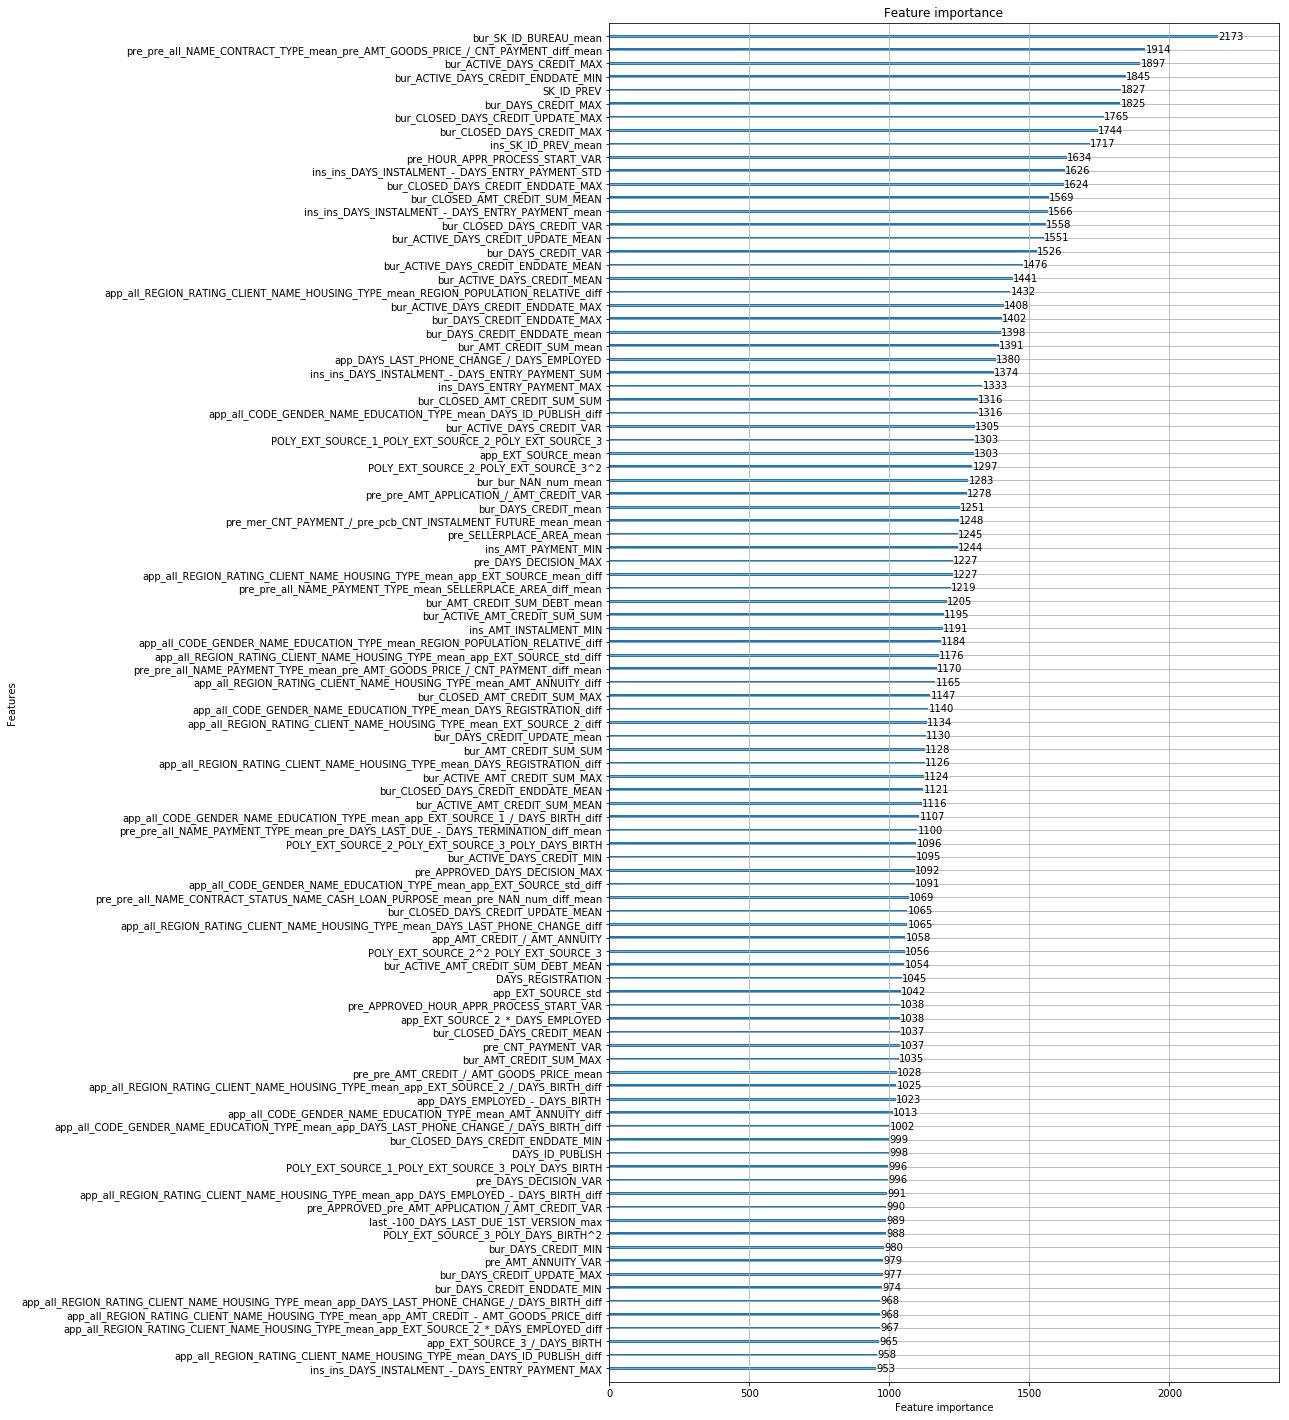

In [10]:
lgb.plot_importance(clf, figsize=(12, 25), max_num_features=100);


### <a id="5.1">5.1 Predict</a>

In [18]:
preds = np.mean(list_preds, axis=0)

#preds = None

    
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("../output/20_all_5kfold.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.018670
1,100005,0.052768
2,100013,0.008339
3,100028,0.018809
4,100038,0.061950


In [12]:
print('20 plus features')
print(sc_auc_score, ',' ,max_score)

20 plus features
0.7913000103505891 , 0.7936581416146465


In [13]:
print('result: ???')

result: ???


In [14]:
feature_importances_list = []

# 特徴量の表示
for i in range(0, clf.feature_importances_.size):
    index = clf.feature_importances_[i]
    feature_importances_list.append([trn_x.columns[i], clf.feature_importances_[i]])
    
    

In [15]:
pd_importancs = pd.DataFrame(feature_importances_list)
pd_importancs.columns = ['features', 'score']
pd_importancs.sort_values('score', ascending=False).to_csv('../output/feature_importances_20_5kfold.csv', index=False)
pd_importancs.sort_values('score', ascending=False)

,features,score
2764,bur SK_ID_BUREAU_mean,2173
1704,pre pre all_NAME_CONTRACT_TYPE_mean_pre AMT_GO...,1914
2825,bur_ACTIVE_DAYS_CREDIT_MAX,1897
2828,bur_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,1845
3104,SK_ID_PREV,1827
2780,bur_DAYS_CREDIT_MAX,1825
2877,bur_CLOSED_DAYS_CREDIT_UPDATE_MAX,1765
2870,bur_CLOSED_DAYS_CREDIT_MAX,1744
2914,ins SK_ID_PREV_mean,1717
2539,pre HOUR_APPR_PROCESS_START_VAR,1634
